# Predicting Groundwater Contaminant Concentrations in the San Joaquin Valley



Fall 2021, Group 10

Barkus, Makena: Worked on data cleaning and input data description for the following features: 'Power Plants', 'Distance to nearest power plant', 'Distance to nearest hazardous waste facility', 'Pesticide application’, 'Hazardous waste sites', 'Leaking underground storage tank cleanup sites','Distance to nearest leaking underground storage tank cleanup sites.’ Worked on merging the 2 big datasets into a final dataset. Also worked on the modeling with Grey, specifically the first model fitting with Linear regression, Ridge, and Lasso,

Hodson, Abby: Worked on data cleaning for target variables, land use classification, soil texture, soil temperature regime, soil hydrologic group, and household water shortages. Wrote abstract, background, ans objective sections.

Huang, Grace: Worked on precipitation data, EDA, and proof-reading.

Smith, Claudia: Worked on the EDA graphs with Grace Huang and the introduction and background research. Worked on interpreting the data and the conclusion as well.

Xu, Grey: Worked mainly on the machine learning model including linear, ridge and lasso regression, cross validation for the optimal parameters and hyper-parameters, and predict the wells that lack of data in the four contaminants.  And I wrote the interpretation and conclusions for this project. Also worked with Abi to clean the target variable data.

In [ ]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install geopandas
import geopandas as gpd
from geopandas import GeoDataFrame
%matplotlib inline
from datetime import datetime
from shapely.geometry import Point
from shapely.ops import nearest_points
!pip install geopy
from geopy.distance import geodesic
pd.options.mode.chained_assignment = None  # default='warn'

# Mount the google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set the path for the directory of interest
mydrive = "/content/drive/MyDrive/ER131_Final_Project"
!ls $mydrive  #double check you have the correct path by listing the contents of that folder

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.3 MB 33.0 MB/s 
     |████████████████████████████████| 15.4 MB 22.2 MB/s 
Mounted at /content/drive
'Abby Data Cleaning.ipynb'		        LUST_Cleanup_Sites
'claudia eda attempt .ipynb'		        makena_data.csv
'Claudia Notes.gdoc'			        merged_1.csv
 County_boundaries			        merged_data.csv
'ER 131 Final Project .gdoc'		       'need_merge (1).csv'
'ER 131 Final Project (Group 10).ipynb'         Pesticide
'ER 131 Project Pitch.gslides'		        Power_plants
 final_merge1.csv			        Precipitation
'Final Project Presentation Group 10.gslides'   Response_Variables
 Groundwater_Level			        Soil
'Hazardous waste'			        Untitled0.ipynb
 Land_Use				        Water_Shortages


## 1. Abstract 

As climate change and increasing agricultural demands exacerbate water insecurity throughout California, understanding which communities are disproportionately burdened by groundwater pollution is essential to distributing safe drinking water and water treatment technology equitably. Though over one million Californians lack access to safe drinking water annually, approximately half of failing drinking water systems are concentrated in small towns and unincorporated communities located throughout the San Joaquin Valley (SJV), an agricultural powerhouse which produces nearly one quarter of the nation's food table (Del Real, 2019). According to a report by the Safe Water Alliance, approximately 95% of San Joaquin Valley residents at least partially rely on groundwater pumped from private wells as a source of domestic water (MacLeod & Estelí Méndez-Barrientos, 2019). However, much of the groundwater in this region is laden with nitrates, arsenic, and other pollutants largely produced by the agricultural industry. Because groundwater monitoring data tends to be concentrated in more heavily populated areas of the SJV, the purpose of this project is to build models which can predict the concentration of four major pollutants, nitrate, arsenic, 1,2,3-trichloropropane (1,2,3-TCP), and uranium in groundwater wells which lack chemical monitoring data. After constructing three types of models (linear regression, ridge regression, and lasso regression) for each contaminant using features like land use classification, soil characteristics, and proximity to hazardous waste sites, we performed model selection using k-fold cross validation.  The optimal models were determined to be lasso regression for nitrate, uranium, and 1,2,3-TCP prediction and linear regression for uranium prediction with testing mean squared errors of 9363, 228, and 74, and 228, respectively. While our nitrate model produced both high training and testing error, low training error exhibited by our models for uranium, arsenic, and 1,2,3-TCP leads us to believe these models might be biased. Consequently, though we are not confident in our contaminant predictions for wells with incomplete chemical monitoring data, this model could be improved by incorporating features more strongly correlated with the target variables.



## 2. Project Background

Spanning from the confluence of the Sacramento and San Joaquin Rivers to the Tehachapi Mountains, the SJV is home to roughly four million people, many of which reside in urban centers surrounded by farmland. Though the majority of the region's population is serviced by municipal water departments, private utilities, and special districts with formal water treatment schemes, tens of thousands of residents rely on contaminated groundwater from domestic wells for drinking water (Ayres et al., 2021). Some of the most prevalent contaminants include nitrate, arsenic, 1,2,3-trichloropropane (1,2,3-TCP), and uranium. Though arsenic and uranium are naturally occuring elements in California's Central Valley, nitrate pollution largely originates from the agricultural industry in the form of fertilizer and manure runoff and 1,2,3-TCP tends to leach into groundwater from industrial and hazardous waste sites. Because these pollutants can be acutely toxic when ingested, groundwater contamination has been a major public health threat since the early 1900's. 


In order to irrigate crops, groundwater has been pumped from aquifers underlying the SJV since the 1930's, causing the entire valley to subside significantly. Coupled with heavy fertilizer application and biased hazardous water facility placement, contaminants easily infiltrate the shallow water table where they can be transported to wells used for drinking water. Though lack of access to clean drinking water is a serious concern throughout the SJV, it is important to note that groundwater pollution is inequitably distributed to Black, Indigenous, and Latinx residents in Central California, particularly with regards to nitrate contamination (Balazs & Morello-Frosch, 2011). Looking more closely at the origins of drinking water disparities in Central California, we see that historical redlining of low-income and minorities communities has resulted disparate access to water treatment infrastructure; for instance, the 1973 Tulare County General Plan witheld "major public facilities such as sewer systems" from "nonviable" communities when developing the regions, continuously opting to expand into undeveloped agricultural parcels rather than connect their watter supply and treatment systems to nearby towns despite taxing these communities for public amenities they cannot access (Balazs & Morello-Frosch, 2011). While selective annexation is just one contributer to drinking water disparities in the SJV, it demonstrates how systemic racism can manifest in the form of environemental inequities. 


With approximately 3.5 billion dollars reserved for improving water infrastructure in California (Hubler, 2021), allocating drinking water treatment infrastructure equitably is essential to mitigating drinking water disparities in the SJV. Though several studies have modeled distributions of environmental risk in this region, a reoccuring issue is the lack of reliable data in rural and unincorporated communities, many of which are theorized to experience the highest exposures to groundwater pollution. CalEnviroScreen in particular has quantified drinking water security in the form of the metric 'drinking water percentile,' a conglomerate metric which describes a community's relative vulnerability to water scarcity and contamination. While this metric takes groundwater pollution into account, it interpolates contaminant concentrations in wells without chemical monitoring data by averaging measurements in nearby wells (Ziese & Blumenfeld, 2021). This modeling strategy can be effective for wells in close proximity to one another, but is less effective for remote wells. Created in hopes of improving upon the drinking water disparity quantifications by other organizations, this project utilizes machine learning to predict contaminant concentrations in groundwater wells with insufficient chemical monitoring data.




## 3. Project Objective
  
Originally inspired by CalEnviroScreen's predictions for drinking water percentile, the objective of this project is to train and evaluate four models capable of predicting nitrate, arsenic, 1,2,3-Trichloropropane, and uranium concentrations in groundwater wells with incomplete groundwater monitoring data for the year 2019. Motived by a lack of complete groundwater monitoring data in rural and unincorporated communities in the SJV, the goal of this project is to create models which can predict concentrations of major pollutants in data-sparse areas. However, because the majority of the data used to train our models is sourced from urban wells in the SVJ, there is a risk of an external validity issue for predicting groundwater pollution in rural wells. Though groundwater pollution is just one aspect of water security in California, we hope that our models can contribute to a more accurate depiction of environmental risk distributions in the Central Valley and help policy makers advocate for more equitable allocation of clean water and water treatment technologies.   


## 4. Input Data Description 

In order to build predictive models for groundwater contamination, we first identified our target variables as annual average nitrate, arsenic, 1,2,3-TCP, and uranium concentrations. Our models are designed to predict these targets for wells with incomplete chemical monitoring data for the year 2019, the most recent year with sufficient data availability. After researching the sources and transport mechanisms of these contaminants, we identified features thought to contribute to groundwater contamination by one or more of the chosen target pollutants. These features include annual average groundwater elevation, land use classification, local climate, soil texture, soil drainage class, soil hydrologic group, annual number of water shortages per county, annual regional precipitation, number of power plants per county, distance to the nearest power plant, distance to nearest hazardous waste site, and regional pesticide application. Though the origins, structure, granularity, scope, temporality, and faithfulness of each dataset are detailed in the following section, a summary of the data used in this project can be found in Table 1.


In [ ]:
table1 = pd.DataFrame(columns = ['Variable','Variable type','Units of measurement','Date of collection','Spatial aggregation','Temporal aggregation', 'Source'])
table1['Variable'] = ['Nitrate concentration','Uranium concentration','1,2,3-TCP Concentration','Arsenic Concentration','Land use classification','Groundwater elevation','Soil temperature regime','Soil texture','Soil hydrologic group','Precipitation','Power Plants','Distance to nearest power plant','Distance to nearest hazardous waste facility','Pesticide application','Household water shortages', 'Hazardous waste sites', 'Leaking underground storage tank cleanup sites','Distance to nearest leaking underground storage tank cleanup sites']
table1['Variable type'] = ['Target','Target','Target','Target','Feature','Feature','Feature','Feature','Feature','Feature','Feature','Feature','Feature','Feature','Feature', 'Feature','Feature', 'Feature']
table1['Units of measurement'] = ['mg/L','pCi/L','ug/L','ug/L','N/A','ft above mean sea level (NAVD88)','N/A','N/A','N/A','in/hour','number/county','mi','mi','lbs/county','number/county', 'number/county', 'number/county', 'mi']
table1['Date of collection'] = ['2018','2018','2018','2018','2018','2018','2011','2011','2011','2019','2021','2021','2021','2018','2018', '2021', '2021', '2021']
table1['Spatial aggregation'] = ['Point locations','Point locations','Point locations','Point locations','Polygons','Point locations','Polygons','Polygons','Polygons','County','County','Point locations','Point locations','County','County', 'County', 'County' ,'Point locations']
table1['Temporal aggregation'] = ['Annual average','Annual average','Annual average','Annual average','Updated once every four years','Annual average','N/A','N/A','N/A','Annual average','Updated Annually','Updated Annually','Updated Daily','Annual average','Annual sum', 'Updated Daily', 'N/A', 'N/A']
table1['Source'] = ['Groundwater   Ambient Monitoring and Assessment  Program','Groundwater   Ambient Monitoring and Assessment  Program','Groundwater   Ambient Monitoring and Assessment  Program','Groundwater   Ambient Monitoring and Assessment  Program','California Department of Water Resources','California Departmnet of Water Resources','National Cooperative Soil Survey','National Cooperative Soil Survey','National Cooperative Soil Survey','National Oceanic and Atmospheric Administration','California Energy Commission','California Energy Commission','Department of Toxic Substances Control Project Management Solution','Department of Pesticide Regulation','California Department of Water Resources', 'Department of Toxic Substances Control Project Management Solution', 'State Water Control Board GeoTracker', 'State Water Control Board GeoTracker']
table1

,Variable,Variable type,Units of measurement,Date of collection,Spatial aggregation,Temporal aggregation,Source
0,Nitrate concentration,Target,mg/L,2018,Point locations,Annual average,Groundwater Ambient Monitoring and Assessmen...
1,Uranium concentration,Target,pCi/L,2018,Point locations,Annual average,Groundwater Ambient Monitoring and Assessmen...
2,"1,2,3-TCP Concentration",Target,ug/L,2018,Point locations,Annual average,Groundwater Ambient Monitoring and Assessmen...
3,Arsenic Concentration,Target,ug/L,2018,Point locations,Annual average,Groundwater Ambient Monitoring and Assessmen...
4,Land use classification,Feature,N/A,2018,Polygons,Updated once every four years,California Department of Water Resources
5,Groundwater elevation,Feature,ft above mean sea level (NAVD88),2018,Point locations,Annual average,California Departmnet of Water Resources
6,Soil temperature regime,Feature,N/A,2011,Polygons,N/A,National Cooperative Soil Survey
7,Soil texture,Feature,N/A,2011,Polygons,N/A,National Cooperative Soil Survey
8,Soil hydrologic group,Feature,N/A,2011,Polygons,N/A,National Cooperative Soil Survey
9,Precipitation,Feature,in/hour,2019,County,Annual average,National Oceanic and Atmospheric Administration


**Nitrate, arsenic, 1,2,3-TCP, and uranium:**

Sourced from the Groundwater Ambient Monitoring and Assessment Program (GAMA), our target variables consist of point location measurements at domestic, municipal, and monitoring wells throughout the state of California. Because different wells are managed by different organizations, mainly the Department of Water Resources, the Department of Pesticide Regulation, and the U.S. Geological Survey, each well has a unique sampling method and frequency. Because more prevalent contaminants like nitrates tend to have more observations than less prevalent contaminants like uranium, one limitation of these datasets is that annual averages of contaminants tend to be more accurate for prevalent contaminants in continuously monitored wells (Figure 1).










Text(0.5, 1.0, 'Figure 1: Groundwater pollutant measurement distribution in the SJV')

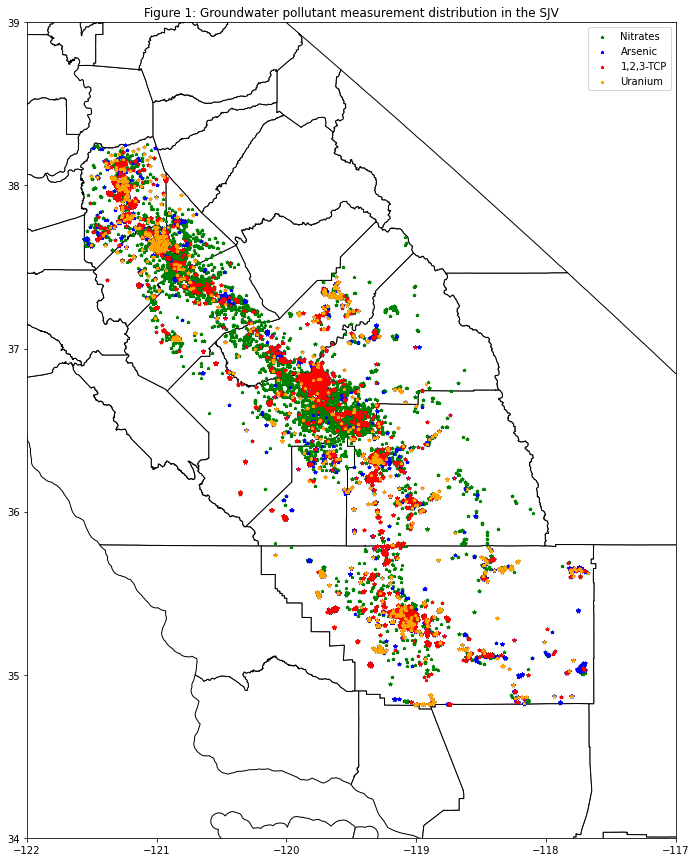

In [ ]:
#import target data for four contaminants: nitrate, arsenic, uranium, 1,2,3-TCP
NO3 = pd.read_csv("/content/drive/MyDrive/ER131_Final_Project/Response_Variables/NO3N.csv")
AS = pd.read_csv("/content/drive/MyDrive/ER131_Final_Project/Response_Variables/AS.csv")
UR =pd.read_csv("/content/drive/MyDrive/ER131_Final_Project/Response_Variables/UR.csv")
TCPR = pd.read_csv("/content/drive/MyDrive/ER131_Final_Project/Response_Variables/TCPR123.csv")
contaminants = [NO3, AS, UR, TCPR]

#convert to geodataframes
NO3 = gpd.GeoDataFrame(NO3)
AS = gpd.GeoDataFrame(AS)
TCPR = gpd.GeoDataFrame(TCPR)
UR = gpd.GeoDataFrame(UR)

#convert lat/long coordinates to gpd point locations
for target in contaminants:
  target = gpd.GeoDataFrame(target, geometry = gpd.points_from_xy(target['GM_LONGITUDE'], target['GM_LATITUDE']))

#import county boundaries
counties = gpd.read_file('/content/drive/MyDrive/ER131_Final_Project/County_boundaries/CA_Counties_TIGER2016.shp')
counties = counties.to_crs(epsg=4326)

#plot distribution of contaminant measurements 
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
NO3.plot(ax= ax,marker='*', color='green', markersize=8, zorder=3, label = 'Nitrates')
AS.plot(ax= ax,marker='*', color='blue', markersize=8, zorder=3, label = 'Arsenic')
TCPR.plot(ax= ax,marker='*', color='red', markersize=8, zorder=3, label = '1,2,3-TCP')
UR.plot(ax= ax,marker='*', color='orange', markersize=8, zorder=3, label = 'Uranium')
counties.plot(ax=ax, color='white', edgecolor='black',zorder = 1)
leg = ax.legend();
plt.xlim([-122,-117])
plt.ylim([34,39])
plt.title('Figure 1: Groundwater pollutant measurement distribution in the SJV')

**Land use classification:**
Because neither dataset exhibited complete coverage of the San Joaquin Valley, land use classification data from two different sources, the Department of Water Resources and the Farmland Mapping and Monitoring Program (FMMP), were combined to create a single predictor for our models. Originally developed from aerial and satellite imagery by Land IQ, LLC, under contract to California Department of Water Resources, the Primary Statewide Crop Mapping dataset consists of shape polygons with an 8-m spatial resolution and associated land use classifications updated as recently as 2018. Also updated in 2018, the secondary land use dataset has similar fields but a coarser resolution of 10 acres. In order to merge the two datasets, similar land use classifications were grouped together and assigned a numeric value (Table 2). However, as pictured in Figure 2, there are some areas, primarily in the foothills of the Sierra Nevadas, which still lack land use classification data.

In [ ]:
#import primary land use data
land_use = gpd.read_file('/content/drive/MyDrive/ER131_Final_Project/Land_Use/i15_Crop_Mapping_2018.shp')

#import secondary land use data for counties with poor coverage
fresno = gpd.read_file('/content/drive/MyDrive/ER131_Final_Project/Land_Use/fresno2018.shp')
kern = gpd.read_file('/content/drive/MyDrive/ER131_Final_Project/Land_Use/kern2018.shp')
tulare = gpd.read_file('/content/drive/MyDrive/ER131_Final_Project/Land_Use/tulare2018.shp')
land_use_backup = fresno.append([kern,tulare])

#convert dataframes to geodataframes with WGS84 CRS
land_use = land_use.to_crs(epsg=4326)
land_use = gpd.GeoDataFrame(land_use)
land_use_backup = land_use_backup.to_crs(epsg=4326)
land_use_backup = gpd.GeoDataFrame(land_use_backup)

Text(0.5, 1.0, 'Figure 3b: Secondary Land Use Classification for SJV (2018)')

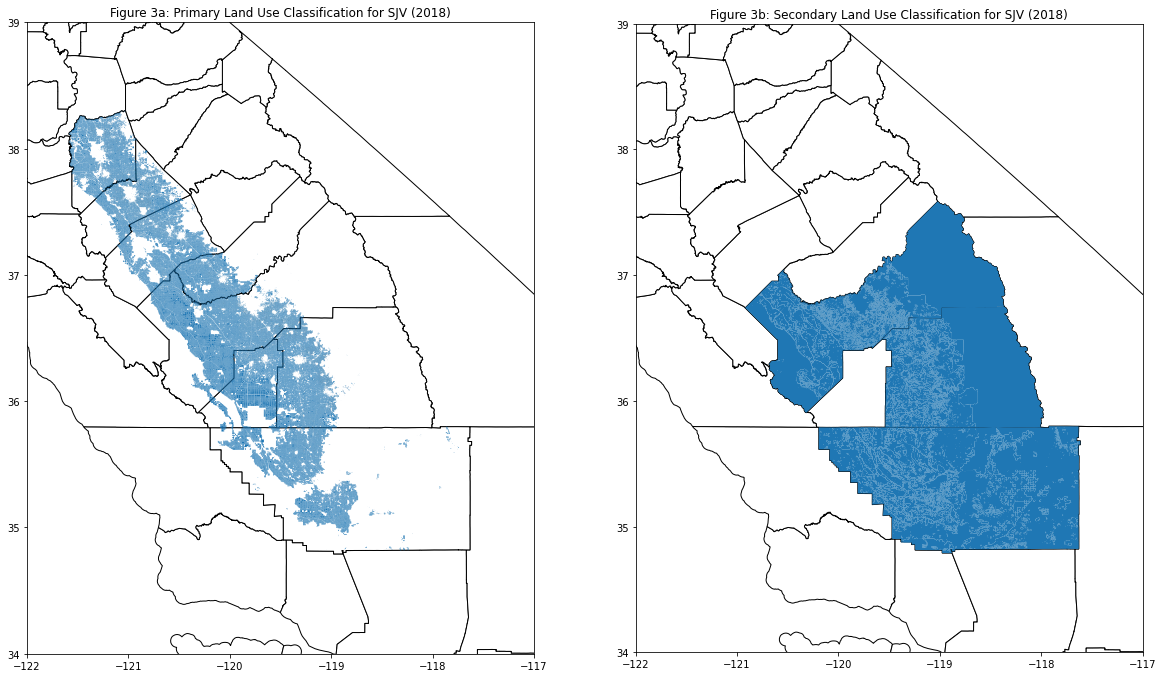

In [ ]:
#plot primary land use classification data 
fig, ((ax1,ax2)) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,20))

ax1.set_aspect('equal')
counties.plot(ax=ax1,color='white', edgecolor='black',zorder = 1)
land_use.plot(ax=ax1,zorder = 2)
ax1.set_xlim([-122,-117])
ax1.set_ylim([34,39])
ax1.set_title('Figure 3a: Primary Land Use Classification for SJV (2018)')

#plot secondary land use classification data 
ax2.set_aspect('equal')
counties.plot(ax=ax2, color='white', edgecolor='black',zorder = 1)
land_use_backup.plot(ax=ax2,zorder = 2)
ax2.set_xlim([-122,-117])
ax2.set_ylim([34,39])
ax2.set_title('Figure 3b: Secondary Land Use Classification for SJV (2018)')


In [ ]:
table2 = pd.DataFrame()
table2['Land Use Classification'] = ['Native vegetation','Pasture','Farmland','Animal agriculture','Semi-agricultural and rural commercial','Rural residential','Urban','Water','Vacant or disturbed land','Not mapped']
table2['Numeric equivalent'] = [0,1,2,3,4,5,6,7,8,9]
table2['Description'] = ['Heavily wooded, rocky or barren areas, riparian and wetland areas, grassland areas which do not qualify for Grazing Land due to their size or land management restrictions, and small water bodies. Constructed wetlands are also included in this category.','Land on which the existing vegetation is suited to the grazing of livestock','Land used for production of irrigated crops within the last four years, includes: grain and hay crops; rice; field crops; truck, nursery, and berry crops; decidous fruits and nuts; citrus and subtropical crops; vineyards; and young perrenials','Aquaculture, dairies, feedlots, and poultry facilities.','Farmsteads, agricultural storage and packing sheds, unpaved parking areas, composting facilities, equine facilities, firewood lots, and campgrounds','Residential areas of one to five structures per ten acres','Occupied by structures with a building density of at least 1 unit to 1.5 acres, or approximately 6 structures to a 10-acre parcel (includes residential, industrial, commercial, institutional facilities, cemeteries, airports, golf courses, sanitary landfills, sewage treatment, and water control structures)','Water areas with an extent of at least 40 acres','Open field areas that do not qualify for an agricultural category, mineral and oil extraction areas, and rural freeway interchanges','Not surveyed or outside of the study area']
table2

,Land Use Classification,Numeric equivalent,Description
0,Native vegetation,0,"Heavily wooded, rocky or barren areas, riparia..."
1,Pasture,1,Land on which the existing vegetation is suite...
2,Farmland,2,Land used for production of irrigated crops wi...
3,Animal agriculture,3,"Aquaculture, dairies, feedlots, and poultry fa..."
4,Semi-agricultural and rural commercial,4,"Farmsteads, agricultural storage and packing s..."
5,Rural residential,5,Residential areas of one to five structures pe...
6,Urban,6,Occupied by structures with a building density...
7,Water,7,Water areas with an extent of at least 40 acres
8,Vacant or disturbed land,8,Open field areas that do not qualify for an ag...
9,Not mapped,9,Not surveyed or outside of the study area


**Groundwater elevation	:**
Managed by the Department of Water Resources, the Periodic Groundwater Level Measurements dataset contains seasonal and longterm measurements collected through the Sustainable Groundwater Management Act Portal’s Monitoring Network Module and the California Statewide Groundwater Elevation Monitoring Program. Similar to the target variable dataset, each monitoring station has a unique measurement method and frequency; however, most measurements are taken manually twice a year to capture the maximum and minimum groundwater elevations at a particular location. Subsequently, wells with more frequent measurements more accurately portray the average annual groundwater elevation at a particular location.



In [ ]:
#import groundwater monitoring data and associated station locations
groundwater = pd.read_csv('/content/drive/MyDrive/ER131_Final_Project/Groundwater_Level/measurements.csv')
stations = pd.read_csv('/content/drive/MyDrive/ER131_Final_Project/Groundwater_Level/stations.csv')


**Soil texture, hydrologic group, and temperature regime:**
Sourced from a digital general soil association map developed by the National Cooperative Soil Survey, this dataset contains three key features which influence the rate at which pollutants can infiltrate the water table and be transported to wells: soil texture, soil hydrologic group, and local climate. Collected in 1- by 2-degree topographic quadrangle units, this dataset consists of shape polygons with associated soil and climate characteristics. Though these features are all qualitative, they each have a natural order which was used to quantify the features (Table 3). For instance, soil hydrologic groups are largely a function of runoff potential, so groupings were quantified from 0-3 with 0 being the smallest runoff potential and 3 being the highest runoff potential. While this dataset has reliable coverage for the SVJ, an important limitation is that it has not been updated since 2011; consequently, the soil characteristic features used in this model could misrepresent the current conditions in central California.




In [ ]:
#import soil characteristic data
soil = gpd.read_file('/content/drive/MyDrive/ER131_Final_Project/Soil/Cal_STATSGO2.shp')

In [ ]:
table3 = pd.DataFrame()
table3['Numeric equivalent'] = [0,1,2,3,4,5,6,7,8,9,10]
table3['Hydrologic group'] = ['A','B','C','D','','','','','','','']
table3['Drainage class'] = ['Very poorly drained','Poorly drained','Somewhat poorly drained','Moderately well drained','Well drained','Somewhat excessively drained','Excessively drained','','','','']
table3['Soil texture'] =  ['Very-fine', 'Fine','Fine-loamy','Coarse-loamy','Loamy', 'Loamy-skeletal','Fine-silty','Clayey','Clayey-skeletal','Sandy-skeletal','Clayey over loamy']
table3['Soil temperature regime'] = ['Isothermic','Thermic','Hyperthermic','Isomesic','Mesic','Frigid','','','','','']
table3

,Numeric equivalent,Hydrologic group,Drainage class,Soil texture,Soil temperature regime
0,0,A,Very poorly drained,Very-fine,Isothermic
1,1,B,Poorly drained,Fine,Thermic
2,2,C,Somewhat poorly drained,Fine-loamy,Hyperthermic
3,3,D,Moderately well drained,Coarse-loamy,Isomesic
4,4,,Well drained,Loamy,Mesic
5,5,,Somewhat excessively drained,Loamy-skeletal,Frigid
6,6,,Excessively drained,Fine-silty,
7,7,,,Clayey,
8,8,,,Clayey-skeletal,
9,9,,,Sandy-skeletal,


**Precipitation:** Precipitation data was acquired from NOAA Local Climatological Data. 
Structure: Data was downloaded in CSV form. The data contains identifying information in the form of station codes (that can be referred to to find the corresponding station, county, and latitude and longitude). 
Granularity: Each entry is an hourly record for one weather station. The data contains columns for hourly recorded features such as altimeter setting, hourly precipitation, wind temperature, among many others.
Scope: The data downloaded covers January 1, 2019 through December 31, 2019. For the stations used in the downloaded dataset, stations reported data throughout the entire 2019 year. The data downloaded covers weather stations representing all 8 counties that fall within San Joaquin Valley.
Temporality: There is a specific hour for each row of the data. 
Faithfulness: There are not inconsistencies found in the data. The data falls within expected ranges. 
The feature **'Avg Precipitation'** was created by aggregating the weather station data by county.




In [ ]:
#original data was downloaded from NOAA Climate Data Online's Hourly "Local Climatological Data" in 6 month blocks (due to limits per download order) and combined into years.
#the large dataframe is filtered to include only the ‘STATION’, ‘DATE’, and ‘HourlyPrecipitation’ columns
SJV_precip = pd.read_csv('/content/drive/MyDrive/ER131_Final_Project/Precipitation/precip2019.csv', dtype={'STATION':str})

**Power Plant features:**
Data on power plants in the San Joaquin Valley was sourced from the Quarterly Fuel and Energy Report (QFER) database from the California Energy Commission (CEC) which records power plant locations and characteristics. 
Structure: the dataset was downloaded from the California Energy Commission's GIS data hub as a CSV file. The fields in this dataset consist of identifying attributes, generator units, energy type, total nameplate capacity, and their owners and operators. Some of the fields are text and some are numbers.
Granularity: each record represents a power plant in California, updated annually. Data can be aggregated for different spatial regions (ie City, County, Zip Code)
Scope: this dataset covers all of California and was updated in 2021. Values for some of the fields are missing but all power plants in California are included.
Temporality: the Last Reported Year field corresponds to the last year that the power plant was recorded in the Annual Generation Table, which is updated annually. Some rows lack data for this field, and some of the power plants were last recorded many years ago. 
Faithfulness: when checking ranges and unique values for different fields, there do not seem to be inconsistencies or errors in the data. 
The feature **'Number Power Plants per County'** was created by aggregating the data by county.
The feature **'Distance to Nearest Power Plant'** was created using the latitude and longitude fields for each power plant to calculate distance to the wells. 




In [ ]:
#import CA power plant data 
CA_power_plants = pd.read_csv('/content/drive/MyDrive/ER131_Final_Project/Power_plants/California_Power_Plants.csv')

**Hazardous Waste Sites features:**
Data on hazardous waste sites in the San Joaquin Valley comes from data from Envirostor, the Department of Toxic Substances Control's Project Management Solution. The DTSC monitors hazardous waste sites and this dataset is updated daily. 
Structure: the dataset was downloaded from the California State Geoportal as a CSV file. The fields include location attributes (such as address, county, coordinates), facility attributes, permit information, and CalEnviroscreen score. 
Granularity: each record represents a facility in California with a unique epa_id. This dataset could be aggregated county, facility type and status, and calenviroscreen score.
Scope: this dataset includes Cleanup Sites, Hazardous Waste Sites, and Inspection, Compliance and Enforcement sites in California. ​​ 
Temporality: This dataset is updated daily and does not include a field related to temporality.
Faithfulness: upon looking at the ranges of values for different fields, there do not seem to be any issues of incorrect or falsified data. 
The feature **'Number Hazardous Waste Sites per County'**	was created by aggregating the data by county.
The feature **'Distance to Nearest Hazardous Waste Sites'** was created using the latitude and longitude fields for each hazardous waste site to calculate distance to the wells.

In [ ]:
#import dataset on hazardous waste sites in California
CA_hazardous_waste_sites = pd.read_csv('/content/drive/MyDrive/ER131_Final_Project/Hazardous waste/Department_of_Toxic_Substances_Control_-_Envirostor_Public_Data_Export (2).csv')

**Pesticide application:**
Data on pesticide application in the San Joaquin Valley comes from the Department of Pesticide Regulation's (DPR) extensive pesticide use and label information (PUR Data Source) through the California Pesticide Information Portal project (CalPIP). To download the dataset, we selected the following criteria: year 2018, counties in the San Joaquin Valley (San Joaquin, Stanislaus, Merced, Madera, Fresno, Kings, Tulare, Kern), and the chemicals ammonium nitrate, arsenic acid, arsenic pentoxide, arsenic trioxide, potassium nitrate, silver nitrate, and sodium nitrate. 
Structure: this dataset was downloaded from CalPIP as a tab-delimited text file. The fields include date, site name and location, product name and pounds applied, chemical name and pounds applied, and aerial ground indicator. Some of the fields are text and some are numbers.
Granularity: each record is unique in some way (ie date, time, location, etc) but some of the rows appear repeated because the unique columns may not be in the output. Data was recorded for various dates and sites, there are several entries for the same date and same site. The data can be aggregated by site, county, product, and aerial ground indicator. 
Scope: CalPIP is a data warehouse that serves up pesticide data produced, maintained, and used by a variety of programs within the Department of Pesticide Regulation (DPR). The dataset we downloaded covers pesticide use in the counties in San Joaquin Valley in 2018. There are a lot of null values for many of the fields including chemical name and pounds of chemical applied.
Temporality: there is a specific date for every record (not unique). Something to note is that NonAg pesticide use reports (non-production-agricultural and non-agricultural applications) are summaries of all applications of a single product over an entire month. They have a default date of the 1st or the 28th, which is not necessarily the actual date of an application. In contrast, the day listed in the date of Ag pesticide use reports (production agricultural applications) is the date a single application was completed.
Faithfulness: There does not appear to be incorrect or unrealistic values or signs of falsified data. 
The feature **'Pesticide Product Applied per County'** was calculated by summing the field POUNDS_PRODUCT_APPLIED for each county.

In [ ]:
#import data on pesticide use in San Joaquin Valley counties for the year 2018
SJV_pesticide_use = pd.read_csv('/content/drive/MyDrive/ER131_Final_Project/Pesticide/Pesticide_use_2018.csv')

**Leaking Underground Storage Tank Sites features:**
The data on Leaking Underground Storage Tank Sites is from the State Water Resources Control Board. 
Structure: the GeoTracker SItes data was downloaded as a csv file from the State Water Board’s GeoTracker database. The fields include general information about the sites (site type, status, location, leakage elements and information, etc).
Granularity: each record represents a facility/site in California, identifiable by a unique GLOBAL_ID. This data can be aggregated by location (county, city), case type, status of site, site history. 
Scope: The dataset covers all of California, so we were able to get sites in San Joaquin Valley. There is a lot of missing data for different fields.
Temporality: There are different fields related to temporality in the dataset, including status date and leak reported date. These dates span a very wide range of years. 
Faithfulness: The data seems reliable, however there are inconsistencies in how information was recorded. For example, in the field 'STOP_DESCRIPTION', some entries are in all uppercase and some in all lowercase. There are likely some spelling errors and inconsistencies in the dataset, but the fields that we used did not seem to have any issues of incorrect or falsified data.
The feature **'Number LUST Cleanup Sites per County'** was created by aggregating the data by county.
The feature **'Distance to Nearest LUST Cleanup Sites'** was created using the latitude and longitude fields for each hazardous waste site to calculate distance to the wells.


In [ ]:
#import dataset on sites tracked in GeoTracker in California
CA_GeoTrackerSites = pd.read_csv('/content/drive/MyDrive/ER131_Final_Project/LUST_Cleanup_Sites/GeoTrackerSites.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



**Household water shortages:**
Motivated by a lack of water shortage data for water systems not regulated at the county level, the Household Water Supply Shortage Reporting System was developed by the Department of Water Resources to encourage cataloguing water shortages at the level of individual households. Instances of water shortages are entered manually along with a date, location, and description of the occurrence. When summed across counties, this dataset can help us understand how water security varies spatially and temporally throughout the SJV. However, because the data entry is voluntary, the collected data are likely under representative of the true number of water shortages.

In [ ]:
#import water shortage data
water_shortages = gpd.read_file('/content/drive/MyDrive/ER131_Final_Project/Water_Shortages/watershortagedata.csv')

## 5. Data Cleaning
In the following section, we describe the logic behind and process of data cleaning for our features and target variables. However, because the script takes several hours to execute, we have included a .csv file with the clean and complete dataframe at the end of this section for ease of interpretation of this notebook.

In [ ]:
#TARGET VARIABLES: NO3, AS, 1,2,3-TCP, and UR CONCENTRATIONS

#drop unecessary columns
NO3.drop(columns = {'GM_RESULT_MODIFIER','GM_REPORTING_LIMIT','GM_WELL_DEPTH_FT','GM_TOP_DEPTH_OF_SCREEN_FT','GM_SCREEN_LENGTH_FT','GM_DATASET_NAME','GM_ALTWELL_ID2','GM_ALTWELL_ID1'}, inplace = True)
AS.drop(columns = {'GM_RESULT_MODIFIER','GM_REPORTING_LIMIT','GM_WELL_DEPTH_FT','GM_TOP_DEPTH_OF_SCREEN_FT','GM_SCREEN_LENGTH_FT','GM_DATASET_NAME','GM_ALTWELL_ID2','GM_ALTWELL_ID1'}, inplace = True)
UR.drop(columns = {'GM_RESULT_MODIFIER','GM_REPORTING_LIMIT','GM_WELL_DEPTH_FT','GM_TOP_DEPTH_OF_SCREEN_FT','GM_SCREEN_LENGTH_FT','GM_DATASET_NAME','GM_ALTWELL_ID2','GM_ALTWELL_ID1'}, inplace = True)
TCPR.drop(columns = {'GM_RESULT_MODIFIER','GM_REPORTING_LIMIT','GM_WELL_DEPTH_FT','GM_TOP_DEPTH_OF_SCREEN_FT','GM_SCREEN_LENGTH_FT','GM_DATASET_NAME','GM_ALTWELL_ID2','GM_ALTWELL_ID1'}, inplace = True)

#filter to only observations in 2019
time_span = pd.DataFrame({'year': [2019,2019],'month': [1, 12],'day': [1, 31]})
time_span = pd.to_datetime(time_span).dt.date
start_date = time_span[0]
end_date = time_span[1]
NO3['GM_SAMP_COLLECTION_DATE'] = pd.to_datetime(NO3['GM_SAMP_COLLECTION_DATE']).dt.date
NO3 = NO3.loc[(NO3['GM_SAMP_COLLECTION_DATE'] >= start_date) & (NO3['GM_SAMP_COLLECTION_DATE'] <= end_date)]
AS['GM_SAMP_COLLECTION_DATE'] = pd.to_datetime(AS['GM_SAMP_COLLECTION_DATE']).dt.date
AS = NO3.loc[(NO3['GM_SAMP_COLLECTION_DATE'] >= start_date) & (AS['GM_SAMP_COLLECTION_DATE'] <= end_date)]
UR['GM_SAMP_COLLECTION_DATE'] = pd.to_datetime(UR['GM_SAMP_COLLECTION_DATE']).dt.date
UR = NO3.loc[(NO3['GM_SAMP_COLLECTION_DATE'] >= start_date) & (UR['GM_SAMP_COLLECTION_DATE'] <= end_date)]
TCPR['GM_SAMP_COLLECTION_DATE'] = pd.to_datetime(TCPR['GM_SAMP_COLLECTION_DATE']).dt.date
TCPR = NO3.loc[(NO3['GM_SAMP_COLLECTION_DATE'] >= start_date) & (TCPR['GM_SAMP_COLLECTION_DATE'] <= end_date)]

#create list of all wells
NO3_wells = pd.DataFrame(NO3['GM_WELL_ID'].unique())
AS_wells = pd.DataFrame(AS['GM_WELL_ID'].unique())
UR_wells = pd.DataFrame(UR['GM_WELL_ID'].unique())
TCPR_wells = pd.DataFrame(TCPR['GM_WELL_ID'].unique())
wells = NO3_wells.append([AS_wells,UR_wells,TCPR_wells])
wells.drop_duplicates(inplace = True)

#create dataframe containing 2019 average contaminant concentrations for each well
average_target = pd.DataFrame(columns = ['GM_WELL_ID','2019 Avg NO3 Cnc','2019 Avg AS Cnc','2019 Avg UR Cnc','2019 Avg TCPR Cnc'])
average_target['GM_WELL_ID'] = wells[0]

#calculate average concentration level for each well in 2019
i = 0;
for well in wells[0]:
    average_target['2019 Avg NO3 Cnc'][i] = NO3.loc[(NO3['GM_WELL_ID'] == well)].mean()[0]
    average_target['2019 Avg AS Cnc'][i] = AS.loc[(AS['GM_WELL_ID'] == well)].mean()[0]
    average_target['2019 Avg UR Cnc'][i] = UR.loc[(UR['GM_WELL_ID'] == well)].mean()[0]
    average_target['2019 Avg TCPR Cnc'][i] = TCPR.loc[(TCPR['GM_WELL_ID'] == well)].mean()[0]  
    i = i + 1

#add geometry column to average_target by merging on well ID
NO3_geometry = NO3.drop(columns = {'GM_RESULT','GM_CHEMICAL_VVL','GM_SAMP_COLLECTION_DATE','GM_RESULT_UNITS'})
average_target = average_target.merge(NO3_geometry, on = 'GM_WELL_ID', how = 'left')

In [ ]:
#GROUNDWATER ELEVATION

#filter to only stations in the SJV
stations = stations[stations['COUNTY_NAME'].isin(['Tulare','Kings','San Joaquin','Kern','Fresno','Stanislaus','Merced','Madera'])]
stations.rename(columns={'SITE_CODE':'Site Code'}, inplace = True)

#drop unecessary columns, rename fields
groundwater.drop(columns = {'WLM_ID','WLM_RPE','WLM_GSE','GSE_GWE','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12','Unnamed: 13'}, inplace = True)
groundwater.rename(columns={'MSMT_DATE':'Date','GWE':'Ground Water Elevation', 'SITE_CODE':'Site Code'},inplace=True)

#merge groundwater dataframe with site code locations
groundwater = pd.merge(groundwater,stations, on ='Site Code')
groundwater.rename(columns={'LATITUDE':'Latitude','LONGITUDE':'Longitude','COUNTY_NAME':'County'}, inplace = True)
wells = groundwater['Site Code']

#filter to 2019
time_span = pd.DataFrame({'year': [2019,2019],'month': [1,  12],'day': [1, 31]})
time_span = pd.to_datetime(time_span).dt.date
start_date = time_span[0]
end_date = time_span[1]
groundwater['Date'] = pd.to_datetime(groundwater['Date']).dt.date
groundwater = groundwater.loc[(groundwater['Date'] >= start_date) & (groundwater['Date'] <= end_date)]

#convert latitude and longitude to gpd point data
groundwater = gpd.GeoDataFrame(groundwater, geometry = gpd.points_from_xy(groundwater['Latitude'], groundwater['Longitude']))

#create empty df for wells with average gw level (ft above sea level)
annual_average_gw = pd.DataFrame(columns = ['Site Code','2019 Avg GWE'])

#remove duplicate wells, add geometry column representing individual well locations
annual_average_gw['Site Code'] = wells.unique()

#calculate average groundwater level for each well in 2019
i = 0;
for well in wells.unique():
    annual_average_gw['2019 Avg GWE'][i] = groundwater.loc[(groundwater['Site Code'] == well)].mean()[0]    
    i = i + 1

#drop empty rows
annual_average_gw.dropna(inplace = True)

#merge annual average and groundwater dataframes on site code to add geometry and county columns to annual average
annual_average_gw = annual_average_gw.merge(groundwater[['Site Code','County','geometry','Latitude','Longitude']],on = 'Site Code')

#create new dataframe to hold merged target and predictive variables 
merged_data = pd.DataFrame(columns = {'Well ID','2019 Avg NO3 Cnc (mg/L)','2019 Avg AS Cnc (mg/L)','2019 Avg UR Cnc (mg/L)','2019 Avg TCPR Cnc (mg/L)','Land Use Classification','Water Shortages (#/county)','2019 Avg GWE','Drainage Class','Hydrologic Group','Texture','Climate','County','geometry','Latitude','Longitude'})
merged_data['Well ID'] = average_target['GM_WELL_ID']
merged_data['2019 Avg NO3 Cnc (mg/L)'] = average_target['2019 Avg NO3 Cnc']
merged_data['2019 Avg AS Cnc (mg/L)'] = average_target['2019 Avg AS Cnc']
merged_data['2019 Avg UR Cnc (mg/L)'] = average_target['2019 Avg UR Cnc']
merged_data['2019 Avg TCPR Cnc (mg/L)'] = average_target['2019 Avg TCPR Cnc']
merged_data['geometry'] = average_target['geometry']
merged_data['Latitude'] = average_target['GM_LATITUDE']
merged_data['Longitude'] = average_target['GM_LONGITUDE']

#because we cannot merge on geometry for the average_target and annual_average_gw dfs, 
#assign individual wells average groundwater elevations based on which target well it is closest to
i = 0
j = 0
distance = []
#iterate through target wells, calculate distance between target and GWE wells
for target_well in average_target['geometry']:
  for feature_well in annual_average_gw['geometry']:
    distance.append(np.sqrt((average_target['GM_LATITUDE'][i]-annual_average_gw['Latitude'][j])**2 + (average_target['GM_LONGITUDE'][i]-annual_average_gw['Longitude'][j])**2))
    j = j + 1
  #find closest target well to GWE well
  closest = np.min(distance)
  closest_index = distance.index(closest)
  #set groundwater elevation in target well equal to that of the closest WE well
  merged_data['2019 Avg GWE'][i] = annual_average_gw['2019 Avg GWE'][closest_index]
  merged_data['County'][i] = annual_average_gw['County'][closest_index]
  distance = []
  i = i + 1
  j = 0

In [ ]:
#LAND USE CLASSIFICATION

#drop unnecessary columns, rename fields
land_use = land_use[['CLASS2','COUNTY','geometry']]
land_use.rename(columns={'CLASS2':'Land Use Classification', 'COUNTY':'County'},inplace = True)

#filter to counties in the SJV
land_use = land_use[land_use['County'].isin(['Tulare','Kings','San Joaquin','Kern','Fresno','Stanislaus','Merced','Madera'])]

#aggregate primary land use classification data and quantify
land_use['Land Use Classification'].loc[land_use['Land Use Classification'].isin(['C','D','F','G','R','T','V','YP','X'])] = 2
land_use['Land Use Classification'].loc[land_use['Land Use Classification'].isin(['P'])] = 1
land_use['Land Use Classification'].loc[land_use['Land Use Classification'].isin(['U','UC','UI','UL','UR','UV'])] = 6
land_use['Land Use Classification'].loc[land_use['Land Use Classification'].isin(['S'])] = 4
land_use['Land Use Classification'].loc[land_use['Land Use Classification'].isin(['NR','NV'])] = 0
land_use['Land Use Classification'].loc[land_use['Land Use Classification'].isin(['NW'])] = 7
land_use['Land Use Classification'].loc[land_use['Land Use Classification'].isin(['I','NB'])] = 8
land_use['Land Use Classification'].loc[land_use['Land Use Classification'].isin(['Z','E'])] = 9

#drop unnecessary columns, rename fields
land_use_backup.drop(columns = {'upd_year','county_nam','polygon_ac','Shape_Leng','Shape_Area'}, inplace = True)
land_use_backup = land_use_backup.rename(columns = {'polygon_ty':'Land Use Classification'})

#aggregate secondary land use classification and quantify
land_use_backup['Land Use Classification'].loc[land_use_backup['Land Use Classification'].isin(['P','S','U','L'])] = 2
land_use_backup['Land Use Classification'].loc[land_use_backup['Land Use Classification'].isin(['G'])] = 1
land_use_backup['Land Use Classification'].loc[land_use_backup['Land Use Classification'].isin(['D'])] = 6
land_use_backup['Land Use Classification'].loc[land_use_backup['Land Use Classification'].isin(['R'])] = 5
land_use_backup['Land Use Classification'].loc[land_use_backup['Land Use Classification'].isin(['sAC'])] = 4
land_use_backup['Land Use Classification'].loc[land_use_backup['Land Use Classification'].isin(['nv'])] = 0
land_use_backup['Land Use Classification'].loc[land_use_backup['Land Use Classification'].isin(['W'])] = 7
land_use_backup['Land Use Classification'].loc[land_use_backup['Land Use Classification'].isin(['V'])] = 8
land_use_backup['Land Use Classification'].loc[land_use_backup['Land Use Classification'].isin(['Z'])] = 9
land_use_backup['Land Use Classification'].loc[land_use_backup['Land Use Classification'].isin(['Cl'])] = 3

#check if target wells are within primary land use polygons, if so, assign land use classification
for idx,row in merged_data.iterrows():
  land_use_temp = land_use[land_use['geometry'].contains(row['geometry'])]
  try:
    merged_data.loc[idx,'Land Use Classification'] = land_use_temp['Land Use Classification'].iloc[0]
  except:
    continue

#populate target wells without land use classification with data from secondary source
i = 0
for well in merged_data['geometry']:
  if pd.isna(merged_data['Land Use Classification'][i]) == True or not merged_data['Land Use Classification'][i]:
    try:
      merged_data['Land Use Classification'][i] = land_use_backup['Land Use Classification'].loc[land_use_backup['geometry'].contains(well)==True].values[0]
    except:
      continue
  i = i + 1

TopologyException: side location conflict at -120.56392502175517 37.02660486481215
TopologyException: side location conflict at -120.56392502175517 37.02660486481215


,Water Shortages (#/county),Climate,2019 Avg TCPR Cnc (mg/L),Latitude,2019 Avg UR Cnc (mg/L),County,2019 Avg GWE,2019 Avg NO3 Cnc (mg/L),Land Use Classification,Drainage Class,Hydrologic Group,geometry,Longitude,Texture,Well ID,2019 Avg AS Cnc (mg/L)
0,NaN,NaN,2.6,37.692100,2.6,Fresno,-87.345,2.6,6,NaN,NaN,POINT (-121.43200 37.69210),-121.432000,NaN,AGC100012333-SJCDW00033,2.6
1,NaN,NaN,9.1,38.113000,9.1,Fresno,-87.345,9.1,6,NaN,NaN,POINT (-121.39200 38.11300),-121.392000,NaN,AGC100012333-SJCDW00037,NaN
2,NaN,NaN,NaN,38.162880,NaN,Fresno,-87.345,1.8,2,NaN,NaN,POINT (-121.25917 38.16288),-121.259169,NaN,AGC100012333-SJCDW00039,1.8
3,NaN,NaN,NaN,38.014830,NaN,Fresno,-87.345,22.6,2,NaN,NaN,POINT (-121.25752 38.01483),-121.257520,NaN,AGC100012333-SJCDW00007,NaN
4,NaN,NaN,NaN,38.039500,NaN,Fresno,-87.345,6.3,5,NaN,NaN,POINT (-121.25180 38.03950),-121.251800,NaN,AGC100012333-SJCDW00002,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12404,NaN,NaN,NaN,36.445778,NaN,Fresno,97.27,2.44,NaN,NaN,NaN,POINT (-119.74283 36.44578),-119.742833,NaN,S3-MACK-K15,NaN
12405,NaN,NaN,NaN,36.513861,NaN,Fresno,125.63,59.5,NaN,NaN,NaN,POINT (-119.71925 36.51386),-119.719250,NaN,S3-MACK-K16,NaN
12406,NaN,NaN,NaN,36.868944,NaN,Fresno,252.3,11,NaN,NaN,NaN,POINT (-119.55803 36.86894),-119.558028,NaN,S3-MACK-K49,NaN
12407,NaN,NaN,NaN,36.520167,NaN,Fresno,264.14,6.34,NaN,NaN,NaN,POINT (-119.48619 36.52017),-119.486194,NaN,S3-MACK-K30,NaN


In [ ]:
#SOIL TEXTURE, TEMPERATURE REGIME, AND HYDROLOGIC GROUP

#drop unecessary columns and empty rows
soil.drop(columns = {'AREASYMBOL','MUSYM','MUKEY','Key','Series','Type','suffix','descriptio','order_','suborder','Great_grou','Subgroup','minerology','salt','Key1'}, inplace = True)
soil.rename(columns={'drainage':'Drainage Class','Hydro_G':'Hydrologic Group','climate':'Climate','texture' : 'Texture'}, inplace = True)
soil.dropna(inplace = True)

#quantify soil hydrologic group
soil['Hydrologic Group'].loc[soil['Hydrologic Group']=='A'] = 0
soil['Hydrologic Group'].loc[soil['Hydrologic Group']=='B'] = 1
soil['Hydrologic Group'].loc[soil['Hydrologic Group']=='C'] = 2
soil['Hydrologic Group'].loc[soil['Hydrologic Group']=='D'] = 3

#quantify soil drainage class
soil['Drainage Class'].loc[soil['Drainage Class']=='Very poorly drained'] = 0
soil['Drainage Class'].loc[soil['Drainage Class']=='Poorly drained'] = 1
soil['Drainage Class'].loc[soil['Drainage Class']=='Somewhat poorly drained'] = 2
soil['Drainage Class'].loc[soil['Drainage Class']=='Moderately well drained'] = 3
soil['Drainage Class'].loc[soil['Drainage Class']=='Well drained'] = 4
soil['Drainage Class'].loc[soil['Drainage Class']=='Somewhat excessively drained'] = 5
soil['Drainage Class'].loc[soil['Drainage Class']=='Excessively drained'] = 6

#quantify soil temperature regime
soil['Climate'].loc[soil['Climate']=='isothermic'] = 0
soil['Climate'].loc[soil['Climate']=='thermic'] = 1
soil['Climate'].loc[soil['Climate']== 'hyperthermic'] = 2
soil['Climate'].loc[soil['Climate']== 'isomesic'] = 3
soil['Climate'].loc[soil['Climate']== 'mesic'] = 4
soil['Climate'].loc[soil['Climate']== 'frigid'] = 5

#quantify soil texture
soil['Texture'].loc[soil['Texture']=='very-fine'] = 0
soil['Texture'].loc[soil['Texture']=='fine'] = 1
soil['Texture'].loc[soil['Texture']=='fine-loamy'] = 2
soil['Texture'].loc[soil['Texture']=='coarse-loamy'] = 3
soil['Texture'].loc[soil['Texture']=='loamy'] = 4
soil['Texture'].loc[soil['Texture']=='loamy-skeletal'] = 5
soil['Texture'].loc[soil['Texture']=='fine-silty'] = 6
soil['Texture'].loc[soil['Texture']=='clayey'] = 7
soil['Texture'].loc[soil['Texture']=='clayey-skeletal'] = 8
soil['Texture'].loc[soil['Texture']=='sandy-skeletal'] = 9
soil['Texture'].loc[soil['Texture']=='clayey over loamy'] = 10
soil['Texture'].loc[soil['Texture']=='medial'] = 11
soil['Texture'].loc[soil['Texture']=='medial-skeletal'] = 12
soil['Texture'].loc[soil['Texture']=='medial over loamy'] = 13
soil['Texture'].loc[soil['Texture']=='medial over loamy-skeletal'] = 14
soil['Texture'].loc[soil['Texture']=='medial-skeletal over loamy-skeletal'] = 15
soil['Texture'].loc[soil['Texture']=='ashy'] = 16
soil['Texture'].loc[soil['Texture']=='ashy-skeletal'] = 17
soil['Texture'].loc[soil['Texture']=='ashy-pumiceous'] = 18
soil['Texture'].loc[soil['Texture']=='cindery'] = 19
soil['Texture'].loc[soil['Texture']=='sandy'] = 20
soil['Texture'].loc[soil['Texture']== 'sandy over clayey'] = 21
soil['Texture'].loc[soil['Texture']=='not used'] = 22

#check if target wells are within soil polygons, assign attributes accordingly
for idx,row in merged_data.iterrows():
  soil_temp = soil[soil['geometry'].contains(row['geometry'])]
  try:
    merged_data.loc[idx,'Drainage Class'] = soil_temp['Drainage Class'].iloc[0]
  except:
    continue
  try:
    merged_data.loc[idx,'Climate'] = soil_temp['Climate'].iloc[0]
  except:
    continue
  try:
    merged_data.loc[idx,'Hydrologic Group'] = soil_temp['Hydrologic Group'].iloc[0]
  except:
    continue
  try:
    merged_data.loc[idx,'Texture'] = soil_temp['Texture'].iloc[0]
  except:
    continue
  try:
    merged_data.loc[idx,'County'] = land_use_temp['County'].iloc[0]
  except:
    continue

In [ ]:
#HOUSEHOLD WATER SHORTAGES

#drop unnecessary columns, filter to only include counties in the SJV
water_shortages.drop(columns = {'Status','Primary Usages','CITY','Was Issue Resolved?','Approximate Repair Cost','Well to Water Depth','Measure Date','Pump Rate Reduction','StatusType','Region','geometry','CREATE DATE','Shortage Type','Household Support','Water Issues','Well Depth','Additional Info','Approximate Issue Start Date','ID','LATITUDE','LONGITUDE'}, inplace = True)
water_shortages = water_shortages.rename(columns={'Report Date':'Date'})
water_shortages = water_shortages[water_shortages['County'].isin(['Tulare','Kings','San Joaquin','Kern','Fresno','Stanislaus','Merced','Madera'])]

#filter to 2019
time_span = pd.DataFrame({'year': [2019, 2019],'month': [1, 12],'day': [1, 31]})
time_span = pd.to_datetime(time_span).dt.date
start_date = time_span[0]
end_date = time_span[1]
water_shortages['Date'] = pd.to_datetime(water_shortages['Date']).dt.date
water_shortages = water_shortages.loc[(water_shortages['Date'] >= start_date) & (water_shortages['Date'] <= end_date)]

#create new dataframe for cleaned water shortage data
water_shortages_clean = pd.DataFrame()
water_shortages_clean['County'] = ['Tulare','Kings','San Joaquin','Kern','Fresno','Stanislaus','Merced','Madera']
water_shortages_clean['Water shortages per county'] = np.nan

#sum water shortages per county for 2018
i = 0;
for county in water_shortages['County'].unique():
    water_shortages_clean['Water shortages per county'][i] = water_shortages.loc[water_shortages['County']==county].shape[0]
    if water_shortages_clean['Water shortages per county'].isna()[i] == True:
      water_shortages_clean['Water shortages per county'][i] = 0
    i = i + 1

#merge water shortage data with full dataframe on county
merged_data = merged_data.merge(water_shortages_clean, on = 'County')

#add column with latitude and longitude coordinates in the format (lat, lon) using function lat_lon()
merged_data['Lat_Lon_wells'] = lat_lon(wells, wells.Latitude, wells.Longitude)

#drop latitude and longitude columns
merged_data.drop(columns=['Latitude', 'Longitude'], inplace = True)

In [ ]:
#SUBFUNCTIONS FOR DATA CLEANING

# function lat_lon() takes in the 2 columns (latitude and longitude) and creates a list of the coordninates for each row in the format (latitude, longitude)
def lat_lon(df, lat_column, lon_column):
    latlon = []
    for i in np.arange(df.shape[0]):
        lat = lat_column.iloc[i]
        lon = lon_column.iloc[i]
        latlon.append((lat, lon))
    return latlon

# function nearest_distance() take the Lat_Lon columns from the 2 dataframes (wells and the powerplant dataframe)
# for each row in the well dataframe:
    # calculates the distance between that well and every powerplant by
    # looping through each row in the powerplant dataframe and calculating the distance between the well and each powerplant
        # min_distance is set to an arbitrary high number so that the first iteration through powerplant df can take its place
        # if that distance is less than the distance calculated for the previous powerplant, it becomes the new min_distance
        # once looped through all of the powerplants (calculating the distance for that 1 well), the lowest distance (which is saved as min_distance) and is added to the list (distances)
    # repeated for each well, adding each minimum distance to the list 'distances', then returns that list    
def nearest_distance(well_latlon, feat_latlon):
    distances = []
    for i in range(len(well_latlon)):
        min_distance = 10000
        well_coord = well_latlon.iloc[i]
        for f in range(len(feat_latlon)):
            feat_coord = feat_latlon.iloc[f]
            dist = geodesic(well_coord, feat_coord).mi
            if dist <= min_distance:
                min_distance = dist
        distances.append(min_distance)
    return distances

In [ ]:
#POWER PLANTS

#select counties in San Joaquin Valley and create new dataframe
SJ_power_plants = CA_power_plants[CA_power_plants.County.str.contains("San Joaquin|Stanislaus|Merced|Madera|Fresno|Kings|Tulare|Kern", regex = True)]

#add column with latitude and longitude coordinates in the format (lat, lon) using function lat_lon()
SJ_power_plants['Lat_Lon_pp'] = lat_lon(SJ_power_plants, SJ_power_plants.Lat_WGS84, SJ_power_plants.Lon_WGS84)

#select only columns 'PlantName', 'County', and 'Lat_Lon' for new dataframe and drop null values
SJ_power_plants.dropna(subset=['Lon_WGS84', 'Lat_WGS84'], inplace=True)
SJ_PowerPlants = SJ_power_plants.loc[:,('PlantName', 'County', 'Lat_Lon_pp')]

# groupby county to find number of powerplants in each county and create new dataframe
Number_PP_county = SJ_PowerPlants.groupby('County').size().to_frame()

#merge number of power plants per county dataframe (Number_PP_county) to wells dataframe
merged_data = merged_data.merge(Number_PP_county, how = 'left', left_on = 'County', right_index = True)
#rename new column 'Number Power Plants per County'
merged_data.rename(columns = {0: 'Number Power Plants per County'}, inplace=True)

#use nearest_distance function using the wells and SJ_PowerPlants dataframes. create new column 'Distance to Nearest Power Plant' in the wells dataframe with a distance to the nearest power plant for each well/row
#**NOTE**: the line of code below takes a long time to run and we have already run it in a different notebook to create our dataset so we decided not to run it in our final notebook
#wells['Distance to Nearest Power Plant'] = nearest_distance(wells.Lat_Lon_wells, SJ_PowerPlants.Lat_Lon_pp)

In [ ]:
#HAZARDOUS WASTE SITES

# select counties in San Joaquin Valley and create new dataframe
SJV_hazardous_waste_sites = CA_hazardous_waste_sites[CA_hazardous_waste_sites.county.str.contains('SAN JOAQUIN|STANISLAUS|MERCED|MADERA|FRESNO|KINGS|TULARE|KERN', regex = True)]

#add column with latitude and longitude coordinates in the format (lat, lon) using function lat_lon()
SJV_hazardous_waste_sites['Lat_Lon_HWS'] = lat_lon(SJV_hazardous_waste_sites, SJV_hazardous_waste_sites.latitude, SJV_hazardous_waste_sites.longitude)

# create new dataframe with columns 'COUNTY' and 'Lat_Lon_HWS'
SJV_HWS = SJV_hazardous_waste_sites.loc[:, ('county', 'Lat_Lon_HWS')]
#change county names from all uppercase to lowercase with uppercase first letter so that we can merge with the wells data set using county names
for i in range(len(SJV_HWS)):
    SJV_HWS.county.iloc[i] = SJV_HWS.county.iloc[i].capitalize()

# groupby county to find number of hazardous waste sites in each county and create new dataframe
Number_HWS_county = SJV_HWS.groupby('county').size().to_frame()

#merge number of hazardous waste sites per county dataframe (Number_HWS_county) to wells dataframe
merged_data = merged_data.merge(Number_HWS_county, how = 'left', left_on = 'County', right_index = True)
#rename new column 'Number Hazardous Waste Sites per County'
merged_data.rename(columns = {0: 'Number Hazardous Waste Sites per County'}, inplace=True)

#use nearest_distance function using the wells and SJV_HWS dataframes. create new column 'Distance to Nearest Hazardous Waste Site' in the wells dataframe with a distance to the nearest hazardous waste site for each well/row
#**NOTE**: the line of code below takes a long time to run and we have already run it in a different notebook to create our dataset so we decided not to run it in our final notebook
#wells['Distance to Nearest Hazardous Waste Sites'] = nearest_distance(wells.Lat_Lon_wells, SJV_HWS.Lat_Lon_HWS)

In [ ]:
#PESTICIDE USE 

#change county names from all uppercase to lowercase with uppercase first letter so that we can merge with the wells data set using county names
for i in range(len(SJV_pesticide_use)):
    SJV_pesticide_use.COUNTY_NAME.iloc[i] = SJV_pesticide_use.COUNTY_NAME.iloc[i].capitalize()

# groupby county and sum the pound of pesticide product applied per county. create new df
Pesticide_Use_county = SJV_pesticide_use.groupby('COUNTY_NAME').sum()[['POUNDS_PRODUCT_APPLIED']]

#merge pounds of pesticide product applied per county dataframe (Pesticide_Use_county) to wells dataframe
merged_data = merged_data.merge(Pesticide_Use_county, how = 'left', left_on = 'County', right_index = True)

#rename new column 'Pesticide Product Applied per County'
merged_data.rename(columns = {'POUNDS_PRODUCT_APPLIED': 'Pesticide Product Applied per County'}, inplace=True)

In [ ]:
#LEAKING UNDERGROUND STORAGE TANK SITES

#create new df that contains only CASE_TYPE as LUST Cleanup Site (Leaking Underground Storage Tank (LUST) Cleanup Sites)
LUST_Cleanup_Sites = CA_GeoTrackerSites.loc[CA_GeoTrackerSites['CASE_TYPE'] == 'LUST Cleanup Site']

#select counties in San Joaquin Valley and create new dataframe
SJV_LUST_Cleanup_Sites = LUST_Cleanup_Sites.loc[LUST_Cleanup_Sites.COUNTY.str.contains("San Joaquin|Stanislaus|Merced|Madera|Fresno|Kings|Tulare|Kern", regex = True)]

#create new dataframe with columns of interest and drop null coordinate values
SJV_LUST = SJV_LUST_Cleanup_Sites.loc[:, ('COUNTY', 'LATITUDE', 'LONGITUDE', 'CASE_TYPE', 'POTENTIAL_MEDIA_OF_CONCERN','CALENVIROSCREEN_SCORE',  'LEAK_REPORTED_DATE')]
SJV_LUST.dropna(subset = ['LATITUDE', 'LONGITUDE'], inplace = True)

#add column with latitude and longitude coordinates in the format (lat, lon) using function lat_lon()
SJV_LUST['Lat_Lon_LUST'] = lat_lon(SJV_LUST, SJV_LUST.LATITUDE, SJV_LUST.LONGITUDE)

#drop null values and create column with year of leak reported
SJV_LUST.dropna(subset=['LEAK_REPORTED_DATE'], inplace = True)
year = []
for i in range(len(SJV_LUST)):
    date = SJV_LUST['LEAK_REPORTED_DATE'].iloc[i]
    dt = datetime.strptime(date, "%m/%d/%y %H:%M")
    year.append(dt.year)
SJV_LUST['Year'] = year

#select years from 2000-2019
SJV_LUST_2000s = SJV_LUST[SJV_LUST['Year'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

# groupby county to find number of LUST Cleanup Sites in each county and create new dataframe
Number_LUST_county = SJV_LUST_2000s.groupby('COUNTY').size().to_frame()

#merge number of LUST Cleanup sites per county dataframe (Number_LUST_county) to wells dataframe
merged_data = merged_data.merge(Number_LUST_county, how = 'left', left_on = 'County', right_index = True)
#rename new column 'Number LUST Cleanup Sites per County'
merged_data.rename(columns = {0: 'Number LUST Cleanup Sites per County'}, inplace=True)

#use nearest_distance function using the wells and SJV_LUST_2000s dataframes. create new column 'Distance to Nearest LUST Cleanup Site' in the wells dataframe with a distance to the nearest LUST Cleanup site for each well/row
#**NOTE**: the line of code below takes a long time to run and we have already run it in a different notebook to create our dataset so we decided not to run it in our final notebook
#wells['Distance to Nearest LUST Cleanup Sites'] = nearest_distance(wells.Lat_Lon_wells, SJV_LUST_2000s.Lat_Lon_LUST)

In [ ]:
#PRECIPITATION

#values in ‘HourlyPrecipitation’ that were blank or ‘T’ (a value used for “Trace amounts of precipitation,” which is near enough 0 to be able to be considered 0 for our purposes) are set to 0. 
SJV_precip['HourlyPrecipitation'] = SJV_precip['HourlyPrecipitation'].fillna(0).replace(np.nan, 0).replace('T', 0)
#Many values also had “s” at the end of them and made them unable to be aggregated, so all values were converted to strings in order to drop the “s,” then converted back to floats for aggregation.
SJV_precip['HourlyPrecipitation'] = SJV_precip['HourlyPrecipitation'].astype(str)
SJV_precip.loc[SJV_precip.HourlyPrecipitation.str.contains("s"), "HourlyPrecipitation"] = SJV_precip[SJV_precip.HourlyPrecipitation.str.contains("s")]["HourlyPrecipitation"].str.replace('s', '')
SJV_precip['HourlyPrecipitation'] = SJV_precip['HourlyPrecipitation'].astype(float)

#rename station codes to line up with county names
SJV_precip['STATION'] = SJV_precip['STATION'].astype(str)
SJV_precip['STATION'] = SJV_precip['STATION'].str.slice(6,11)

#HourlyPrecipitation data was summed for a year
SJV_precip = SJV_precip.groupby("STATION").sum()[["HourlyPrecipitation"]]

SJV_precip.rename(columns = {'HourlyPrecipitation':'TotalAnnualPrecipitation'}, inplace = True)

#Corresponding COUNTY information was added for each station code. 
SJV_precip['COUNTY'] = ['Kern',
                          'Kern',
                          'Kings',
                          'Kern',
                          'Tulare',
                          'Kern',
                          'Merced',
                          'San Joaquin',
                          'Merced',
                          'Stanislaus',
                          'Kings',
                          'Kern',
                          'Kern',
                          'Tulare',
                          'Fresno',
                          'Madera',
                          'Merced',
                          ]
#sums were averaged across stations within a county in order to reach average total precipitation per county
SJV_precip = SJV_precip.groupby('COUNTY').mean()

# #select precipitation for the year 2019 to match the year of wells
# SJV_precip_2019 = SJV_precipitation.loc[:, ('COUNTY', '2019 Precip')]
SJV_precip.rename(columns = {'COUNTY': 'County'}, inplace=True)

#merge average precipitation for 2019 to wells data on county  
merged_data = merged_data.merge(SJV_precip, how = 'left', on = 'County')
merged_data.rename(columns = {'TotalAnnualPrecipitation': 'Avg Precipitation'}, inplace = True)

#export to csv file
#merged_data.to_csv('final_merge1.csv')

## 6. Data Summary and Exploratory Data Analysis

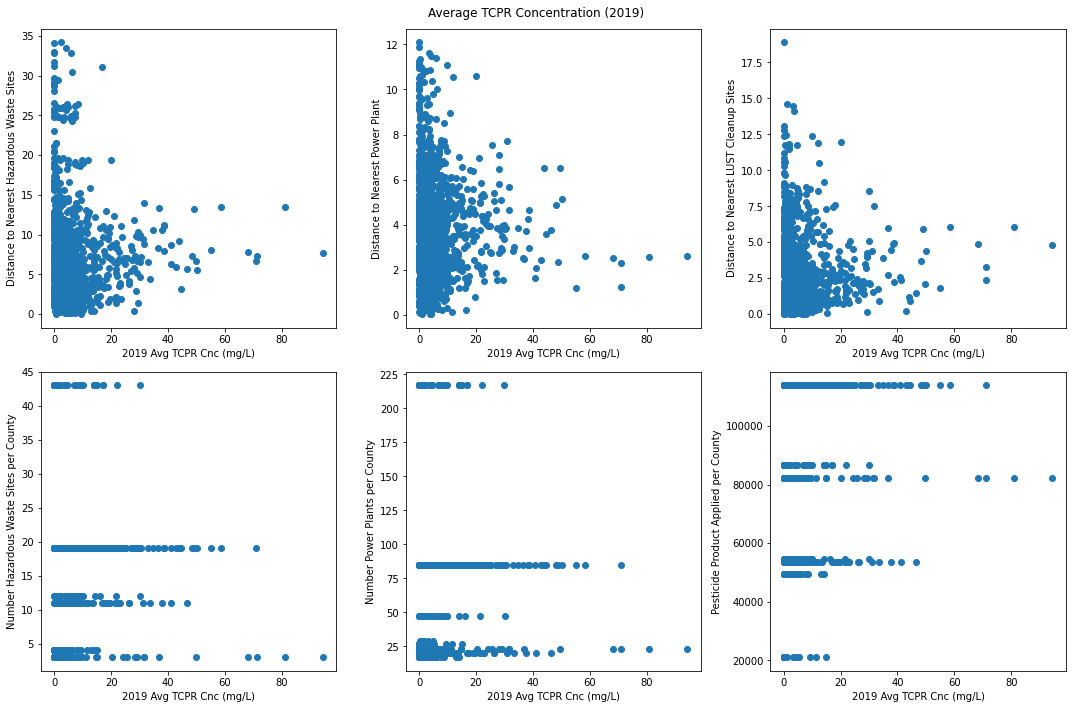

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ER131_Final_Project/final_merge1.csv', index_col=0)

fig, (ax1,ax2) = plt.subplots(2,3, figsize = (15,10))
ax1[0].scatter(x = data["2019 Avg TCPR Cnc (mg/L)"], y = data["Distance to Nearest Hazardous Waste Sites"])
ax1[0].set(xlabel="2019 Avg TCPR Cnc (mg/L)", ylabel="Distance to Nearest Hazardous Waste Sites")

ax1[2].scatter(x = data["2019 Avg TCPR Cnc (mg/L)"], y = data["Distance to Nearest LUST Cleanup Sites"])
ax1[2].set(xlabel="2019 Avg TCPR Cnc (mg/L)", ylabel="Distance to Nearest LUST Cleanup Sites")


ax2[2].scatter(x= data["2019 Avg TCPR Cnc (mg/L)"], y= data['Pesticide Product Applied per County'])
ax2[2].set(xlabel="2019 Avg TCPR Cnc (mg/L)", ylabel="Pesticide Product Applied per County")


ax1[1].scatter(x = data["2019 Avg TCPR Cnc (mg/L)"], y = data["Distance to Nearest Power Plant"])
ax1[1].set(xlabel="2019 Avg TCPR Cnc (mg/L)", ylabel="Distance to Nearest Power Plant")

ax2[1].scatter(x = data["2019 Avg TCPR Cnc (mg/L)"], y = data["Number Power Plants per County"])
ax2[1].set(xlabel="2019 Avg TCPR Cnc (mg/L)", ylabel="Number Power Plants per County")

ax2[0].scatter(x = data['2019 Avg TCPR Cnc (mg/L)'], y = data['Number Hazardous Waste Sites per County'])
ax2[0].set(xlabel="2019 Avg TCPR Cnc (mg/L)", ylabel="Number Hazardous Waste Sites per County")

plt.suptitle("Average TCPR Concentration (2019)")
plt.tight_layout()
fig.subplots_adjust(top=.95)
plt.show()

The variables that use distance seem to be better for understanding what features influence the presence of TPCR in the well measurements. There appears to be a negative correlation between the 2019 average TCPR concentration and distance to the nearest hazardous waste sites, distance to nearest power plants, and distance to the nearest LUST cleanup sites. However, the number of hazardous waste sites and power plants per county do not seem to be helpful in determining which features are important for the prediction of TCPR concentration, most likely because numerical county measurements do not show how close to the wells the plants are, which is covered by the distance features. The pesticide product applied per county was similarly unhelpful, as the pesticide product applied per county does not say much about where it was applied in relation to the wells. 

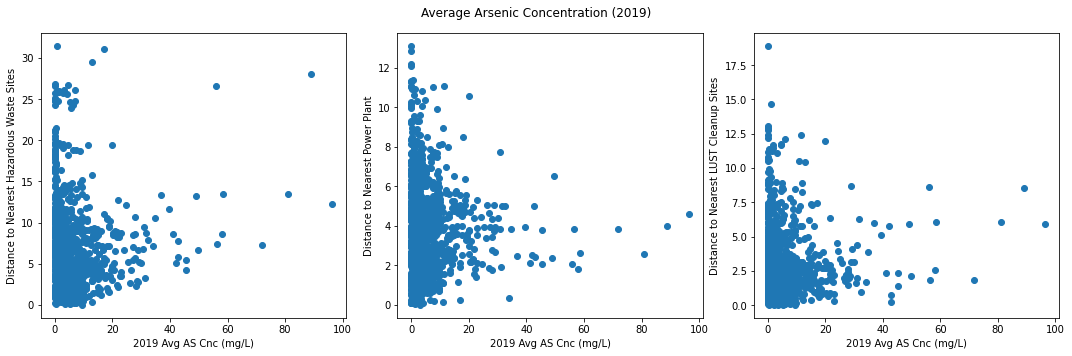

In [ ]:
fig, (ax1) = plt.subplots(1,3, figsize = (15,5))
ax1[0].scatter(x = data["2019 Avg AS Cnc (mg/L)"], y = data["Distance to Nearest Hazardous Waste Sites"])
ax1[0].set(xlabel="2019 Avg AS Cnc (mg/L)", ylabel="Distance to Nearest Hazardous Waste Sites")

ax1[2].scatter(x = data["2019 Avg AS Cnc (mg/L)"], y = data["Distance to Nearest LUST Cleanup Sites"])
ax1[2].set(xlabel="2019 Avg AS Cnc (mg/L)", ylabel="Distance to Nearest LUST Cleanup Sites")

ax1[1].scatter(x = data["2019 Avg AS Cnc (mg/L)"], y = data["Distance to Nearest Power Plant"])
ax1[1].set(xlabel="2019 Avg AS Cnc (mg/L)", ylabel="Distance to Nearest Power Plant")

fig.suptitle("Average Arsenic Concentration (2019)")
fig.subplots_adjust(top=.6)
plt.tight_layout()
plt.show()

The average arsenic concentrations proved similar in their negative correlation with distance to nearest hazardous waste sites, distance to nearest powerr plants, and distance to nearest LUST cleanup sites. This shows that all of these distances might be significant features for predicting arsenic concentrations in wells without measurements. 

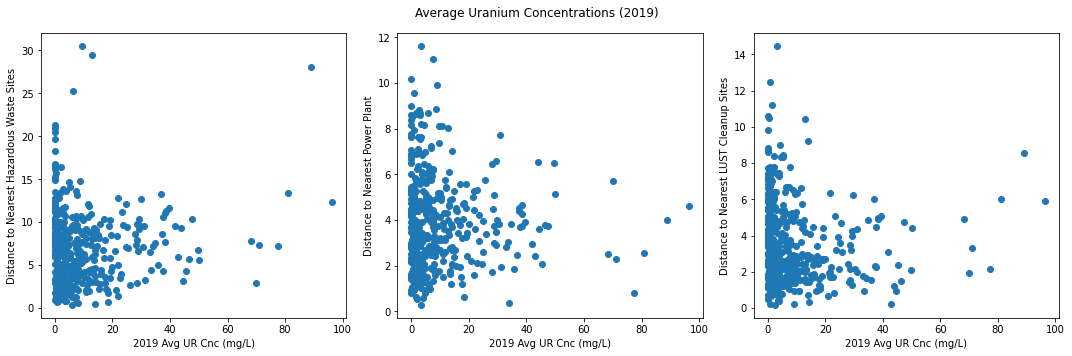

In [ ]:
fig, (ax1) = plt.subplots(1,3, figsize = (15,5))
ax1[0].scatter(x = data["2019 Avg UR Cnc (mg/L)"], y = data["Distance to Nearest Hazardous Waste Sites"])
ax1[0].set(xlabel="2019 Avg UR Cnc (mg/L)", ylabel="Distance to Nearest Hazardous Waste Sites")

ax1[2].scatter(x = data["2019 Avg UR Cnc (mg/L)"], y = data["Distance to Nearest LUST Cleanup Sites"])
ax1[2].set(xlabel="2019 Avg UR Cnc (mg/L)", ylabel="Distance to Nearest LUST Cleanup Sites")

ax1[1].scatter(x = data["2019 Avg UR Cnc (mg/L)"], y = data["Distance to Nearest Power Plant"])
ax1[1].set(xlabel="2019 Avg UR Cnc (mg/L)", ylabel="Distance to Nearest Power Plant")

fig.suptitle("Average Uranium Concentrations (2019)")
fig.subplots_adjust(top=.6)
plt.tight_layout()
plt.show()

Similar to the arsenic and TCPR concentrations, there appears to be a negative correlation between uranium concentrations and distance to nearest hazardous waste sites, distance to nearest power plants, and distance to nearest LUST cleanup sites. This shows a preliminary implication that hazardous waste sites, power plants, and LUST cleanup sites could be significant factors in predicting uranium concentration. 

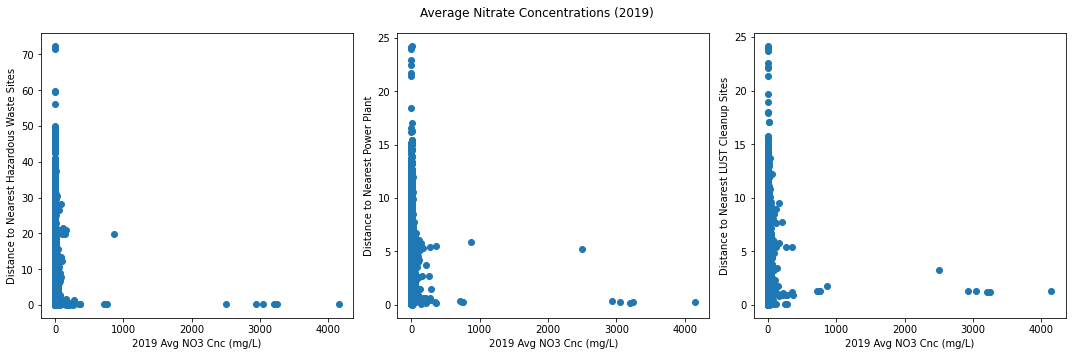

In [ ]:
fig, (ax1) = plt.subplots(1,3, figsize = (15,5))
ax1[0].scatter(x = data["2019 Avg NO3 Cnc (mg/L)"], y = data["Distance to Nearest Hazardous Waste Sites"])
ax1[0].set(xlabel="2019 Avg NO3 Cnc (mg/L)", ylabel="Distance to Nearest Hazardous Waste Sites")

ax1[2].scatter(x = data["2019 Avg NO3 Cnc (mg/L)"], y = data["Distance to Nearest LUST Cleanup Sites"])
ax1[2].set(xlabel="2019 Avg NO3 Cnc (mg/L)", ylabel="Distance to Nearest LUST Cleanup Sites")

ax1[1].scatter(x = data["2019 Avg NO3 Cnc (mg/L)"], y = data["Distance to Nearest Power Plant"])
ax1[1].set(xlabel="2019 Avg NO3 Cnc (mg/L)", ylabel="Distance to Nearest Power Plant")

fig.suptitle("Average Nitrate Concentrations (2019)")
fig.subplots_adjust(top=.6)
plt.tight_layout()
plt.show()

For the nitrate concentration measurements, the negative correlation between nitrate concentration and distance to nearest hazardous waste sites, distance to nearest power plants, and distance to nearest LUST cleanup sites is not present. This implies that these factors are not as significant in predicting nitrate concentration for wells without measurements. 

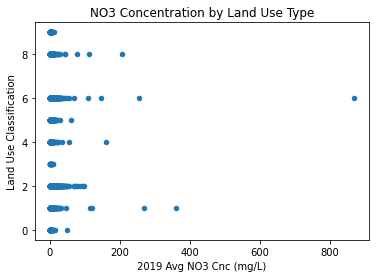

In [ ]:
TCPR_var = "2019 Avg TCPR Cnc (mg/L)"
UR_var = "2019 Avg UR Cnc (mg/L)"
AS_var = "2019 Avg AS Cnc (mg/L)"
NO3_var = "2019 Avg NO3 Cnc (mg/L)"

data.plot.scatter(NO3_var, 'Land Use Classification', title = "NO3 Concentration by Land Use Type");

Land Use is primarily a categorical variable. Plotting nitrate concentrations against Land Use Classification reveals the land use types with higher concentrations of nitrates. We expect nitrates to be more present in land use types that are more agricultural and would be more likely to make heavy use of nitrate-heavy fertilizers. Certain wells with higher concentrations of nitrates appear to be in land use types such as Category 1 (Pasture), Category 2 (Farmland), Category 6 (urban) and Category 8 (Vacant land). Note: there are no data points that have Land type 7 because that is considered "Water," and wells are not present in water.

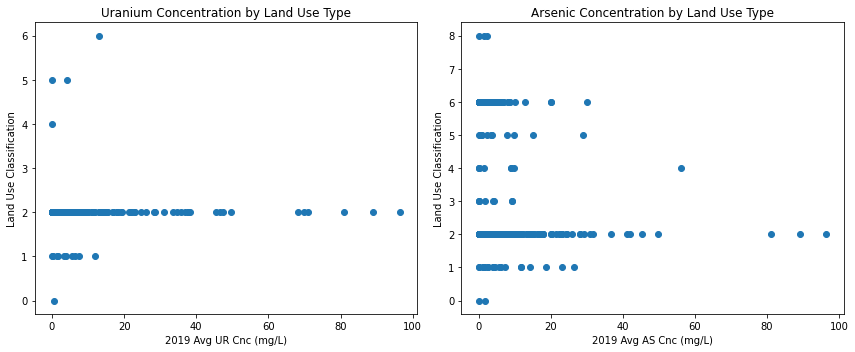

In [ ]:
fig,ax1 = plt.subplots(1,2, figsize = (12,5))

ax1[0].scatter(x = data['2019 Avg UR Cnc (mg/L)'], y = data['Land Use Classification'])
ax1[0].set(title = "Uranium Concentration by Land Use Type", ylabel = "Land Use Classification", xlabel = "2019 Avg UR Cnc (mg/L)")

ax1[1].scatter(x= data['2019 Avg AS Cnc (mg/L)'], y = data['Land Use Classification'])
ax1[1].set(title = "Arsenic Concentration by Land Use Type", ylabel = "Land Use Classification", xlabel = "2019 Avg AS Cnc (mg/L)")

plt.tight_layout()
plt.show()

Plotting uranium concentrations against Land Use reveals that most uranium concentration measurements fall under Category 2 (Farmland). It appears that the highest uranium concentrations (in the high 90s) appear in Farmland land types. Category 1 (Pasture) also has a notable range of higher uranium concentrations. Some uranium is expected to be present because uranium is a naturally occurring substance. 

Plotting arsenic concentrations against Land Use reveals that, again, higher concentrations are most present in Farmland. Other categories where higher concentrations of arsenic are present include Pasture (1), Semi-Agricultural (4), Rural (5), and Urban (6). These are high compared to Category 0, which represents Native Vegetation. Arsenic is also a naturally occurring substance.

## 7. Forecasting and Prediction Modeling

##### 7.1 Prediction models: Linear Regression, Ridge, and Lasso 

We decided to include all of our features in our matrix for each of our four prediction problems, and then use the Lasso and Ridge regression models to identify the variables that are not important predictors for particular problems. To regularize the term, we will use both Ridge and Lasso regression in our prediction questions to avoid the problem of overfitting.

In [ ]:
#import modeling packages
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context("talk")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
# Load the cleaned data set with target variables and features for each well in the San Joaquin Valley
df = pd.read_csv('/content/drive/MyDrive/ER131_Final_Project/final_merge1.csv', index_col=0)
df.head(10)

,geometry,County,2019 Avg TCPR Cnc (mg/L),2019 Avg NO3 Cnc (mg/L),2019 Avg UR Cnc (mg/L),2019 Avg AS Cnc (mg/L),2019 Avg GWE,Lat_Lon_wells,Number Power Plants per County,Distance to Nearest Power Plant,Pesticide Product Applied per County,Number Hazardous Waste Sites per County,Distance to Nearest Hazardous Waste Sites,Number LUST Cleanup Sites per County,Distance to Nearest LUST Cleanup Sites,Avg Precipitation,Drainage Class,Hydrologic Group,Water Shortages (#/county),Land Use Classification,Climate,Texture
0,POINT (-121.432 37.6921),Fresno,2.6,2.6,2.6,2.6,-80.06,"(37.6921, -121.432)",85,3.495775,113928.0661,19.0,1.423454,176,0.171232,17.55,4.0,2.0,4.0,NaN,1.0,1.0
1,POINT (-121.392 38.113),Fresno,9.1,9.1,9.1,NaN,-80.06,"(38.113, -121.392)",85,1.734511,113928.0661,19.0,10.747385,176,0.193500,17.55,NaN,NaN,4.0,NaN,NaN,NaN
2,POINT (-121.259169 38.16288),Fresno,NaN,1.8,NaN,1.8,-80.06,"(38.16288, -121.259169)",85,2.514463,113928.0661,19.0,12.411724,176,0.592909,17.55,4.0,1.0,4.0,NaN,1.0,3.0
3,POINT (-121.25752 38.01483),Fresno,NaN,22.6,NaN,NaN,-80.06,"(38.01483, -121.25752)",85,4.483159,113928.0661,19.0,2.516438,176,0.375913,17.55,NaN,NaN,4.0,NaN,NaN,NaN
4,POINT (-121.2518 38.0395),Fresno,NaN,6.3,NaN,NaN,-80.06,"(38.0395, -121.2518)",85,6.189718,113928.0661,19.0,4.175026,176,1.357752,17.55,NaN,NaN,4.0,NaN,NaN,NaN
5,POINT (-121.2487 38.0262),Fresno,4.1,4.1,4.1,4.1,-80.06,"(38.0262, -121.2487)",85,5.284338,113928.0661,19.0,3.436507,176,0.615677,17.55,NaN,NaN,4.0,NaN,NaN,NaN
6,POINT (-121.248255 37.69011),Fresno,0.0,0.0,NaN,0.0,-80.06,"(37.69011, -121.248255)",85,7.308658,113928.0661,19.0,7.257210,176,6.391526,17.55,NaN,NaN,4.0,NaN,NaN,NaN
7,POINT (-121.24819 37.79028),Fresno,NaN,2.8,NaN,NaN,-80.06,"(37.79028, -121.24819)",85,1.967621,113928.0661,19.0,1.957385,176,0.917770,17.55,3.0,1.0,4.0,NaN,1.0,3.0
8,POINT (-121.22798 37.82013),Fresno,8.3,8.3,NaN,8.3,-80.06,"(37.82013, -121.22798)",85,1.552111,113928.0661,19.0,2.471844,176,1.610175,17.55,3.0,1.0,4.0,NaN,1.0,3.0
9,POINT (-121.2215 38.0147),San Joaquin,0.6,0.6,NaN,0.6,-80.06,"(38.0147, -121.2215)",29,4.865417,NaN,NaN,3.411186,93,1.982095,26.83,4.0,2.0,4.0,2.0,1.0,1.0


For Linear Regression, Ridge, and Lasso, we first created an X matrix with only our features and a y matrix with our response variable. Then we created four dataframes (X_train, X_test, y_train, y_test) containing the training and testing subsets of the feature matrix X and response matrix y. We split into 20% test and 80% training using the train_test_split function from sklearn. We used the function get_Xy() from homework 8 to create the 4 dataframes X_train, X_test, y_train, and y_test. We added a strategy input and set it to ‘most frequent’ using SimpleImputer to deal with missing values when standardizing the data.

We used the generalized function `get_Xy()` that takes as input a dataframe, `df`; a list of columns to drop , `cols_to_drop`; the name of the column holding the response variable, `y_col`; the proportion of the data to hold out as the test subset, `test_size`; and a random seed, `random_state`. Features are standardized, then split into training and testing.

The SimpleImputer class provides basic strategies for imputing missing values. Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located. This class also allows for different missing values encodings.

In [ ]:
def get_Xy(df, cols_to_drop, y_col, test_size, random_state,strategy):
    """
    This function returns four dataframes containing the testing and training X and y values used in land-use regression.
    Input: df, a Pandas dataframe with all of the fields in the land-use regression dataset; 
        cols_to_drop, a list of the names (strings) of the columns to drop from df in order to obtain the feature variables.
        y_col, a column name (as a string) of df that represents the response variable
        test_size, a float between 0 and 1 indicating the fraction of the data to include in the test split
        random_state, an integer, used to define the random state
    Returns: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the 
    feature matrix X and response matrix y
    """
    
    # Replace the ellipses with your code
    X = df.drop(columns = cols_to_drop) # The X dataframe should be a subset of df; make sure to drop the columns in the cols_to_drop list
    y = df.loc[:,y_col] # The column of df containing the response variable
    
    # Standardize the data
    scaler = StandardScaler()
    scaler.fit(X) 
    X_stnd = scaler.transform(X)

    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imp.fit(X_stnd)
    SimpleImputer()
    X_stnd = imp.transform(X_stnd)

    X_train, X_test, y_train, y_test = train_test_split(X_stnd, y, test_size = test_size, random_state = random_state)
    
    return X_train, X_test, y_train, y_test

We're going to compare the results of three models: a simple linear regression, ridge regression, and lasso regression. Once we created our training and test sets, we fit model to the data in the training set of X and y, using the 3 models Linear Regression, Ridge, and Lasso. We used the fit_model() function from homework 8 to fit a model to the training data and compute the MSE, a list of model coefficients, and R-square for a specific model. First, we initialize a model and save that instance of the model to a variable. Then the function fits the inputed model to the training data, using model.fit(), where the model is either LinearRegression, or Ridge/Lasso using the inputted alpha/lambda value. Next, the function finds the predicted y values or the test data using model.predict(). Finally, the MSE of the test data is computed using the mean_squared_error() function, coefficients are stored in an array using model.coef_, and the R-square is computed using model.score(). 

The function `fit_model()` automates the process of initializing a model, fitting that model, and getting predictions. The function returns three sets of values: 
1. The test (or validation) mean squared error of the model (a single float value).
2. The model coefficients (a list of float values); and 
3.  The R-square (a single float value)

In [ ]:
def fit_model(SKL_model, X_train, X_test, y_train, y_test, alpha = 1):
    """
    This function fits a model of type SKL_model to the data in the training set of X and y, and finds the MSE on the test set of X and y.
    Inputs: 
        SKL_model: the type of sklearn model with which to fit the data. Options include: LinearRegression, Ridge, or Lasso.
        X_train: the set of features used to train the model.
        y_train: the set of response variable observations used to train the model.
        X_test: the set of features used to test the model.
        y_test: the set of response variable observations used to test the model.
        alpha: the penalty parameter (also known as lambda), to be used with Ridge and Lasso models only.
    """    
    
    # Initialize the model, differentiating between models that require and do not require the alpha parameter
    if SKL_model == LinearRegression:
        model = SKL_model()
    else:
        model = SKL_model(alpha = alpha)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Fit the model on the training data and get the mean squared error on the test data
    
    mse = mean_squared_error(y_test, y_pred)
    coef = model.coef_.flatten() # This line ensures your function returns a 1D array of coefficients
    r_sq = model.score(X_train, y_train)
    
    return mse, coef, r_sq

##### 7.1.1 Prediction on Nitrate

We created a dataframe (df_nitrate) with rows that have a value for our response variable, in this case nitrate (don’t include rows with null values, these rows will be used for prediction).

In [ ]:
df_nitrate = df[df['2019 Avg NO3 Cnc (mg/L)'].notna()]

In [ ]:
# Need total here as the colums that needs to be drop for X dataframe
total = ['geometry','County','2019 Avg TCPR Cnc (mg/L)','2019 Avg UR Cnc (mg/L)','2019 Avg AS Cnc (mg/L)','Lat_Lon_wells','2019 Avg NO3 Cnc (mg/L)']
X_nitrate_train, X_nitrate_test, y_nitrate_train, y_nitrate_test = get_Xy(df_nitrate, total, '2019 Avg NO3 Cnc (mg/L)', test_size = 0.2, random_state =2021, strategy='most_frequent')

We fit the model 3 times on the training and testing data for the full dataset of nitrate: with `SKL_model = LinearRegression`, with `SKL_model = Ridge` and with `SKL_model = Lasso`. We used the function get_Xy() to create X_nitrate_train, X_nitrate_test, y_nitrate_train, y_nitrate_test.
For ridge and lasso, we leave alpha value as its default value (1) for this part. The same process is repeated for arsenic, uranium, and TCPR.


In [ ]:
Models = [LinearRegression, Ridge, Lasso]

# initialize an array that will hold the MSE values. Each element corresponds to a model in Models 
mse_nitrate = np.full(len(Models),np.nan)

# initialize an array that will hold coefficients. Each row is a coefficient, and each column corresponds to a different type of model in Models
coef_nitrate = np.full((X_nitrate_train.shape[1], len(Models)),np.nan)

# initialize an array that will hold the R-square values of the training model
rsq_nitrate = np.full(len(Models),np.nan)

for m in range(len(Models)): 
    mse_nitrate[m], coef_nitrate[:,m], rsq_nitrate[m] = fit_model(Models[m],X_nitrate_train, X_nitrate_test, y_nitrate_train, y_nitrate_test) # Replace the ellipses with your code


Text(0.5, 1.0, 'Coefficient values with three model from the full dataset (nitrate)')

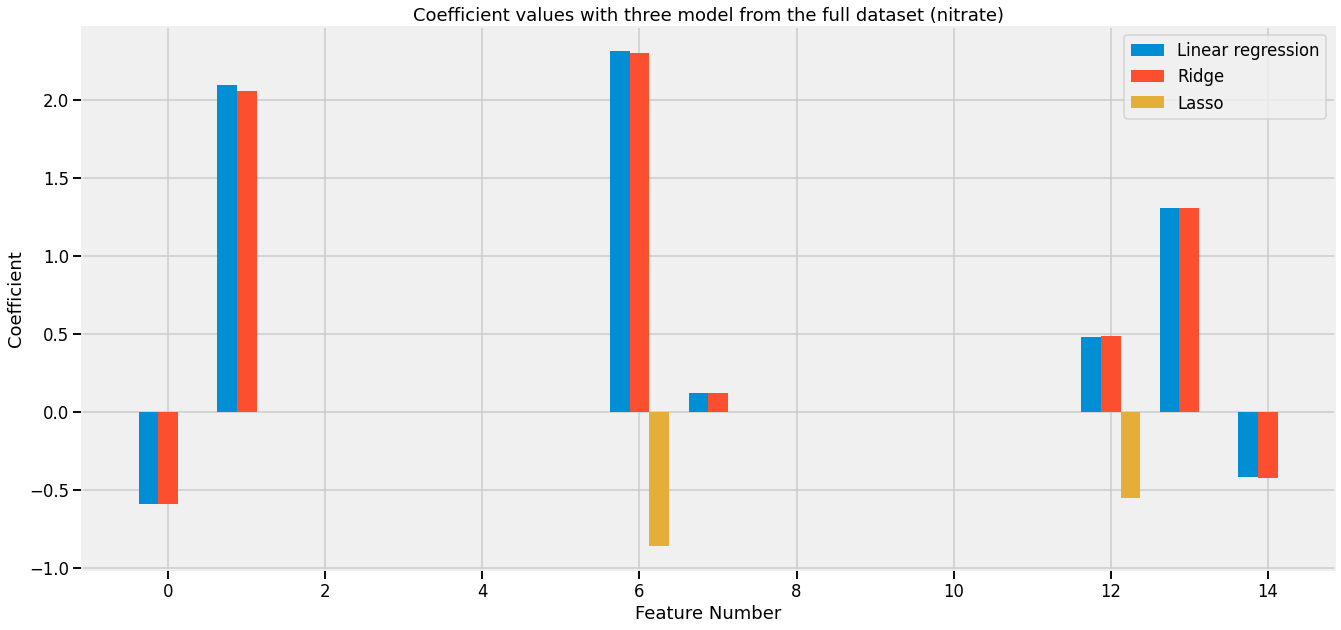

In [ ]:
# Create a subplot to compare three models for Nitrate Prediction.
ind = np.arange(len(coef_nitrate)) # we want our bar chart to have one set of bars for each feature
width = 0.25  # This line and the following one set up the positions for each set of bars
pos = np.array([ind - width, ind, ind + width])
modelNames = ["Linear regression", "Ridge", "Lasso"] # you might want to use these as the labels in the your bar plots

plt.figure(figsize = (20,10))

# Plot the coefficients for Linear, Ridge, and Lasso models fit using data for nitrate states
for i in np.arange(len(modelNames)): # loop through each type of model (OLS, Ridge, Lasso)
    plt.bar(x = pos[i], height = np.log(coef_nitrate[:,i]), width = width, label = modelNames[i])
plt.legend()
plt.xlabel("Feature Number")
plt.ylabel("Coefficient")
plt.title("Coefficient values with three model from the full dataset (nitrate)")


In [ ]:
#Compare the 3 test MSES from the full dataset for nitrate.
print("Linear Regression MSE for nitrate:",mse_nitrate[0])
print("Ridge Regression MSE for nitrate:",mse_nitrate[1])
print("Lasso Regression MSE for nitrate:",mse_nitrate[2])

print("Linear Regression R-square for nitrate:",rsq_nitrate[0])
print("Ridge Regression R-square for nitrate:",rsq_nitrate[1])
print("Lasso Regression R-square for nitrate:",rsq_nitrate[2])

Linear Regression MSE for nitrate: 9367.641428765524
Ridge Regression MSE for nitrate: 9367.526606391177
Lasso Regression MSE for nitrate: 9375.643448717226
Linear Regression R-square for nitrate: 0.00947637627835407
Ridge Regression R-square for nitrate: 0.009476241855512546
Lasso Regression R-square for nitrate: 0.007151974519810755


Since the Linear/Ridge/Lasso Regression model seems to be ill-performed. We tried with the regression tree to see the results.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

tuned_tree = DecisionTreeRegressor(random_state=2021)
tuned_tree.fit(X_nitrate_train, y_nitrate_train)

y_nitrate_pred = tuned_tree.predict(X_nitrate_test)
mse_tree = mean_squared_error(y_nitrate_test, y_nitrate_pred)
print("Tree Regression MSE for nitrate:", mse_tree)

Tree Regression MSE for nitrate: 13403.010662547787


##### 7.1.2 Prediction on Arsenic

In [ ]:
df_arsenic = df[df['2019 Avg AS Cnc (mg/L)'].notna()]
X_arsenic_train, X_arsenic_test, y_arsenic_train, y_arsenic_test = get_Xy(df_arsenic, total, '2019 Avg AS Cnc (mg/L)', test_size = 0.2, random_state =2021, strategy="most_frequent")

In [ ]:
Models = [LinearRegression, Ridge, Lasso]

# initialize an array that will hold the MSE values. Each element corresponds to a model in Models 
mse_arsenic = np.full(len(Models),np.nan)

# initialize an array that will hold coefficients. Each row is a coefficient, and each column corresponds to a different type of model in Models
coef_arsenic = np.full((X_arsenic_train.shape[1], len(Models)),np.nan)

# initialize an array that will hold the R-square values of the training model
rsq_arsenic = np.full(len(Models),np.nan)

for m in range(len(Models)): 
    mse_arsenic[m], coef_arsenic[:,m], rsq_arsenic[m] = fit_model(Models[m],X_arsenic_train, X_arsenic_test, y_arsenic_train, y_arsenic_test) # Replace the ellipses with your code


Text(0.5, 1.0, 'Coefficient values with three model from the full dataset (arsenic)')

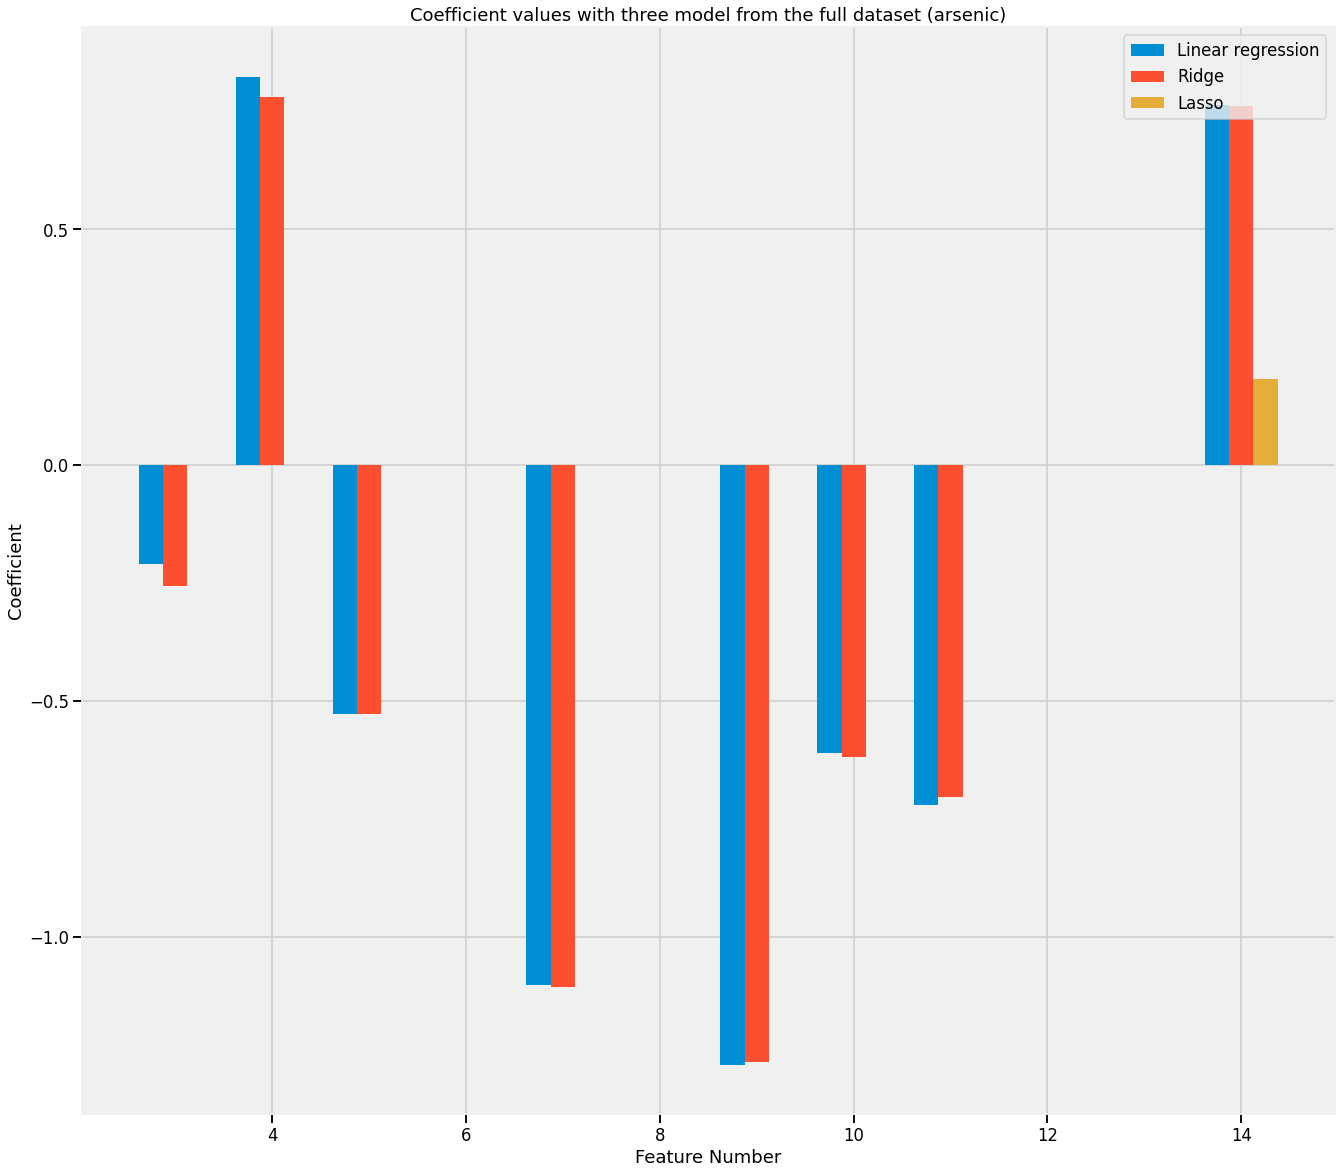

In [ ]:
# Create a subplot to compare three models.
ind = np.arange(len(coef_arsenic)) # we want our bar chart to have one set of bars for each feature
width = 0.25  # This line and the following one set up the positions for each set of bars
pos = np.array([ind - width, ind, ind + width])
modelNames = ["Linear regression", "Ridge", "Lasso"] # you might want to use these as the labels in the your bar plots

plt.figure(figsize = (20,20))

# Plot the coefficients for Linear, Ridge, and Lasso models fit using data for arsenic states
for i in np.arange(len(modelNames)): # loop through each type of model (OLS, Ridge, Lasso)
    plt.bar(x = pos[i], height = np.log(coef_arsenic[:,i]), width = width, label = modelNames[i])
plt.legend()
plt.xlabel("Feature Number")
plt.ylabel("Coefficient")
plt.title("Coefficient values with three model from the full dataset (arsenic)")

In [ ]:
#Compare the 3 test MSES from the full dataset for arsenic.
print("Linear Regression MSE for arsenic:",mse_arsenic[0])
print("Ridge Regression MSE for arsenic:",mse_arsenic[1])
print("Lasso Regression MSE for arsenic:",mse_arsenic[2])

print("Linear Regression R-square for arsenic:",rsq_arsenic[0])
print("Ridge Regression R-square for arsenic:",rsq_arsenic[1])
print("Lasso Regression R-square for arsenic:",rsq_arsenic[2])

Linear Regression MSE for arsenic: 70.91206395036889
Ridge Regression MSE for arsenic: 70.95456094328537
Lasso Regression MSE for arsenic: 74.13435247739389
Linear Regression R-square for arsenic: 0.09116834324727885
Ridge Regression R-square for arsenic: 0.09116286520050088
Lasso Regression R-square for arsenic: 0.04847609117510321


##### 7.1.3 Prediction on Uranium

In [ ]:
df_uranium = df[df['2019 Avg UR Cnc (mg/L)'].notna()]
X_uranium_train, X_uranium_test, y_uranium_train, y_uranium_test = get_Xy(df_uranium,total,'2019 Avg UR Cnc (mg/L)', test_size = 0.2, random_state =2021,strategy='most_frequent')

In [ ]:
Models = [LinearRegression, Ridge, Lasso]

# initialize an array that will hold the MSE values. Each element corresponds to a model in Models 
mse_uranium = np.full(len(Models),np.nan)

# initialize an array that will hold coefficients. Each row is a coefficient, and each column corresponds to a different type of model in Models
coef_uranium = np.full((X_uranium_train.shape[1], len(Models)),np.nan)

# initialize an array that will hold the R-square values of the training model
rsq_uranium = np.full(len(Models),np.nan)

for m in range(len(Models)): 
    mse_uranium[m], coef_uranium[:,m], rsq_uranium[m] = fit_model(Models[m],X_uranium_train, X_uranium_test, y_uranium_train, y_uranium_test) # Replace the ellipses with your code


Text(0.5, 1.0, 'Coefficient values with three model from the full dataset(uranium)')

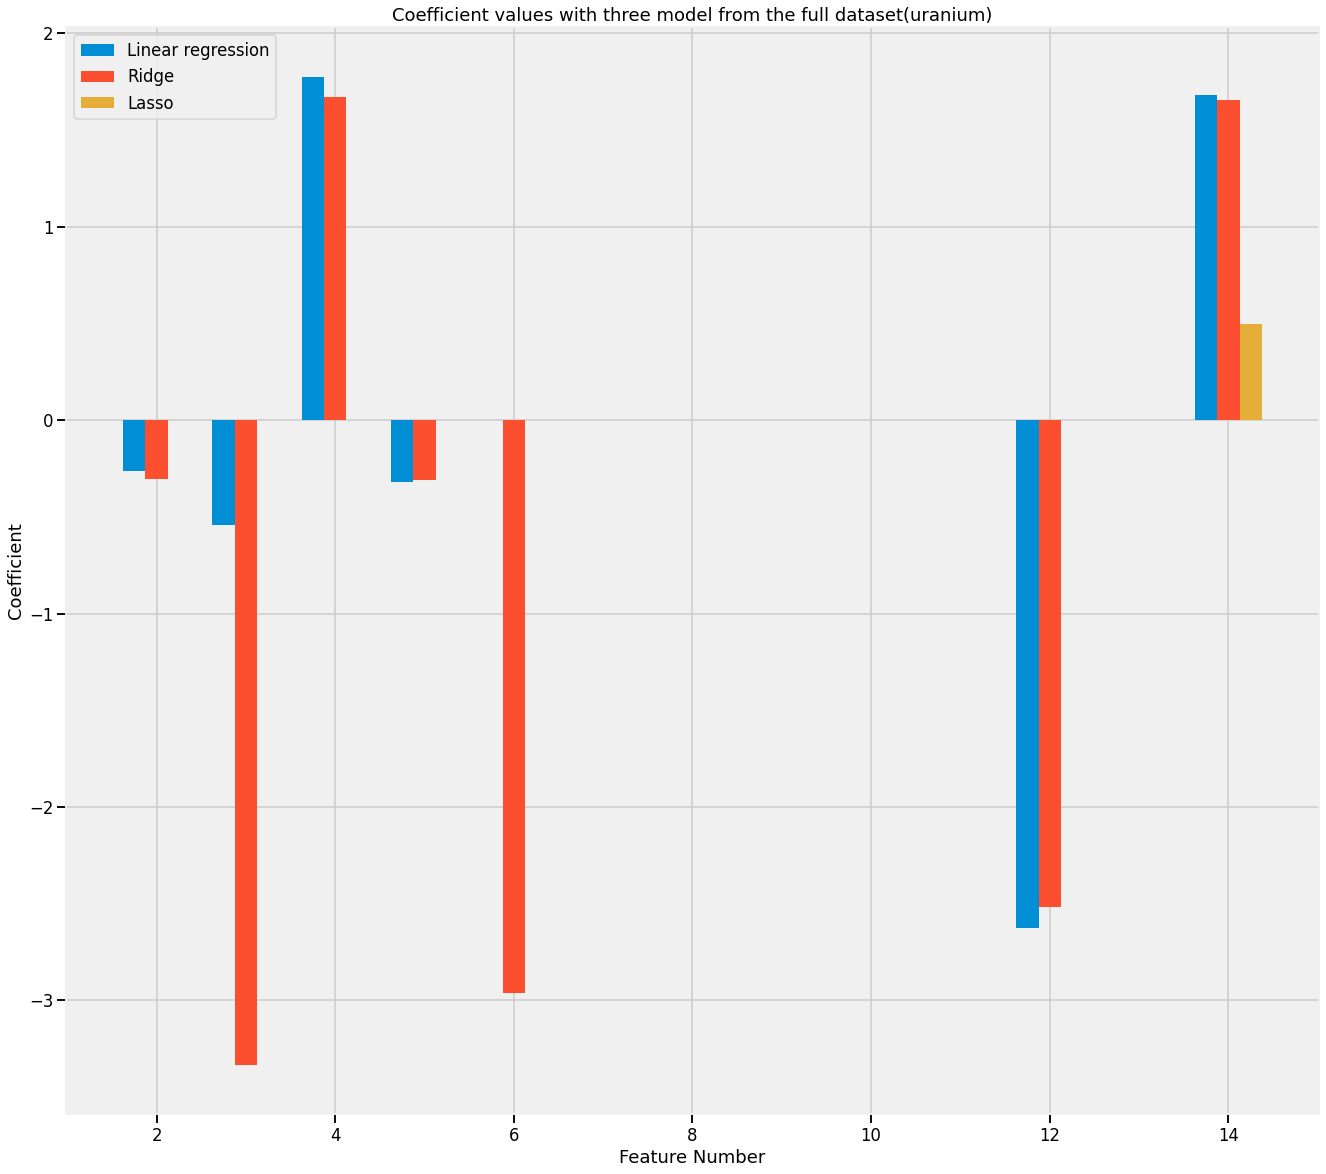

In [ ]:
# Create a subplot to compare three models.
ind = np.arange(len(coef_uranium)) # we want our bar chart to have one set of bars for each feature
width = 0.25  # This line and the following one set up the positions for each set of bars
pos = np.array([ind - width, ind, ind + width])
modelNames = ["Linear regression", "Ridge", "Lasso"] # you might want to use these as the labels in the your bar plots

plt.figure(figsize = (20,20))

# Plot the coefficients for Linear, Ridge, and Lasso models fit using data for uranium states
for i in np.arange(len(modelNames)): # loop through each type of model (OLS, Ridge, Lasso)
    plt.bar(x = pos[i], height = np.log(coef_uranium[:,i]), width = width, label = modelNames[i])
plt.legend()
plt.xlabel("Feature Number")
plt.ylabel("Coefficient")
plt.title("Coefficient values with three model from the full dataset(uranium)")

In [ ]:
#Compare the 3 test MSES from the full dataset for uranium.
print("Linear Regression MSE for uranium:",mse_uranium[0])
print("Ridge Regression MSE for uranium:",mse_uranium[1])
print("Lasso Regression MSE for uranium:",mse_uranium[2])

print("Linear Regression R-square for uranium:",rsq_uranium[0])
print("Ridge Regression R-square for uranium:",rsq_uranium[1])
print("Lasso Regression R-square for uranium:",rsq_uranium[2])

Linear Regression MSE for uranium: 228.82849861736716
Ridge Regression MSE for uranium: 229.1223345119916
Lasso Regression MSE for uranium: 238.2750076842579
Linear Regression R-square for uranium: 0.1337216197590183
Ridge Regression R-square for uranium: 0.13356556148131493
Lasso Regression R-square for uranium: 0.08057974325456929


##### 7.1.4 Prediction on TCPR

In [ ]:
df_TCPR = df[df['2019 Avg TCPR Cnc (mg/L)'].notna()]
X_TCPR_train, X_TCPR_test, y_TCPR_train, y_TCPR_test = get_Xy(df_TCPR,total, '2019 Avg TCPR Cnc (mg/L)', test_size = 0.2, random_state =2021, strategy="most_frequent")

In [ ]:
Models = [LinearRegression, Ridge, Lasso]

# initialize an array that will hold the MSE values. Each element corresponds to a model in Models 
mse_TCPR = np.full(len(Models),np.nan)

# initialize an array that will hold coefficients. Each row is a coefficient, and each column corresponds to a different type of model in Models
coef_TCPR = np.full((X_TCPR_train.shape[1], len(Models)),np.nan)

# initialize an array that will hold the R-square values of the training model
rsq_TCPR = np.full(len(Models),np.nan)

for m in range(len(Models)): 
    mse_TCPR[m], coef_TCPR[:,m], rsq_TCPR[m] = fit_model(Models[m],X_TCPR_train, X_TCPR_test, y_TCPR_train, y_TCPR_test) # Replace the ellipses with your code

Text(0.5, 1.0, 'Coefficient values with three model from the full dataset(TCPR)')

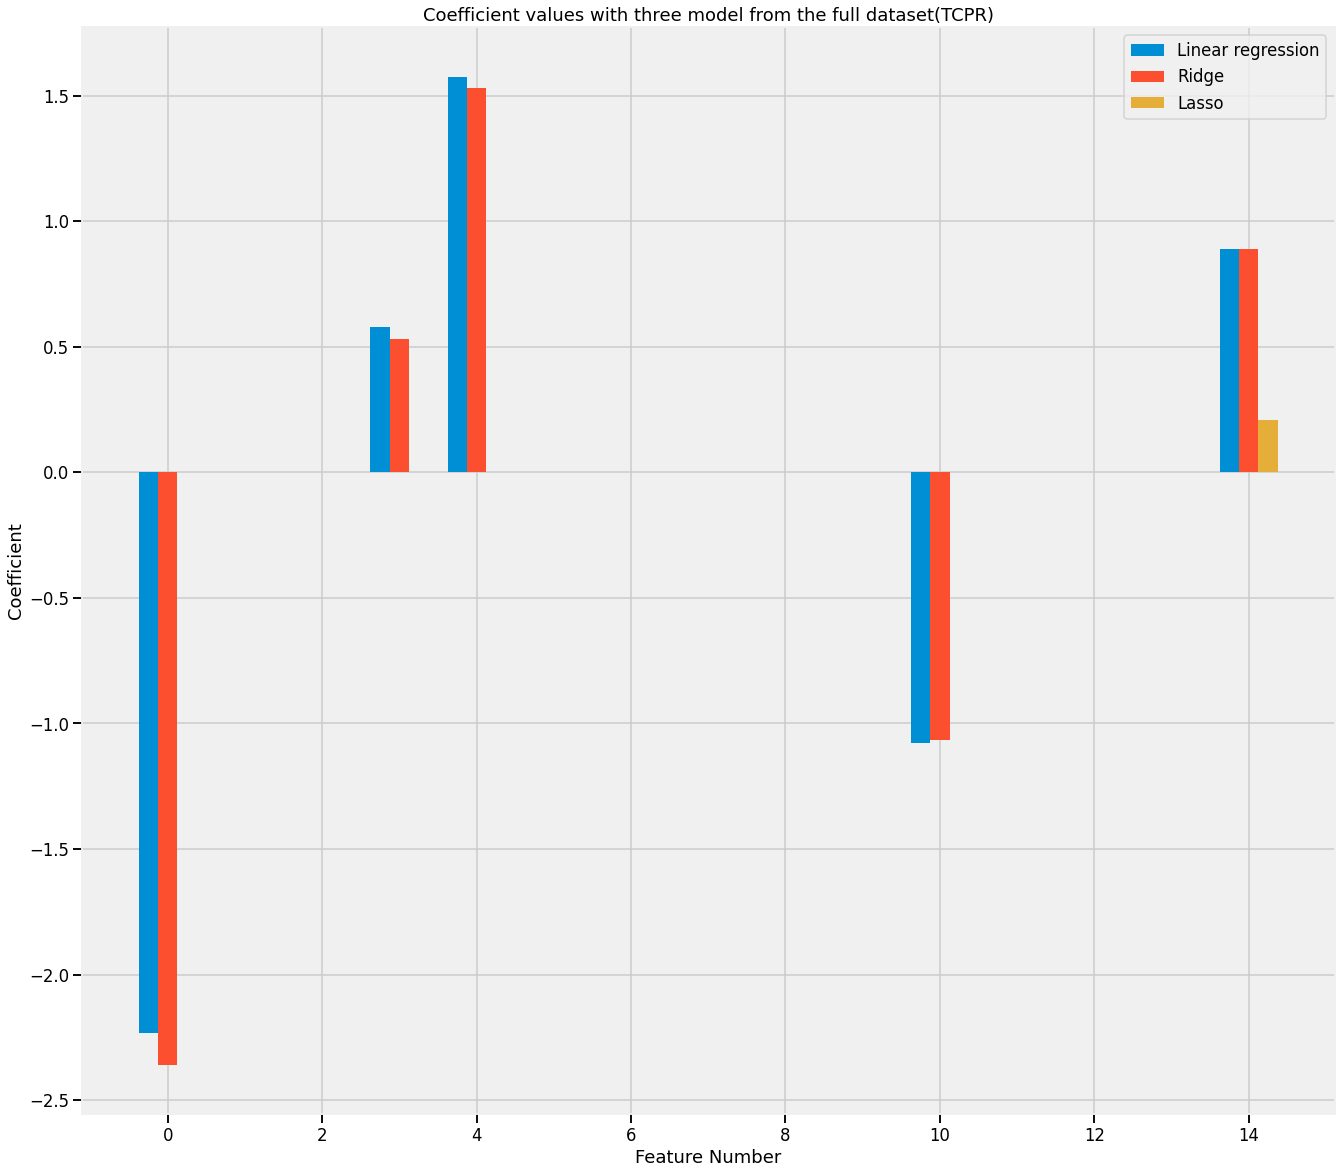

In [ ]:
# Create a subplot to compare three models.
ind = np.arange(len(coef_TCPR)) # we want our bar chart to have one set of bars for each feature
width = 0.25  # This line and the following one set up the positions for each set of bars
pos = np.array([ind - width, ind, ind + width])
modelNames = ["Linear regression", "Ridge", "Lasso"] # you might want to use these as the labels in the your bar plots

plt.figure(figsize = (20,20))

# Plot the coefficients for Linear, Ridge, and Lasso models fit using data for TCPR states
for i in np.arange(len(modelNames)): # loop through each type of model (OLS, Ridge, Lasso)
    plt.bar(x = pos[i], height = np.log(coef_TCPR[:,i]), width = width, label = modelNames[i])
plt.legend()
plt.xlabel("Feature Number")
plt.ylabel("Coefficient")
plt.title("Coefficient values with three model from the full dataset(TCPR)")

In [ ]:
#Compare the 3 test MSES from the full dataset for TCPR.
print("Linear Regression MSE for TCPR:",mse_TCPR[0])
print("Ridge Regression MSE for TCPR:",mse_TCPR[1])
print("Lasso Regression MSE for TCPR:",mse_TCPR[2])
print("Linear Regression R-square for TCPR:",rsq_TCPR[0])
print("Ridge Regression R-square for TCPR:",rsq_TCPR[1])
print("Lasso Regression R-square for TCPR:",rsq_TCPR[2])

Linear Regression MSE for TCPR: 74.40557276385931
Ridge Regression MSE for TCPR: 74.39180711911419
Lasso Regression MSE for TCPR: 74.01786284023962
Linear Regression R-square for TCPR: 0.11077125535669263
Ridge Regression R-square for TCPR: 0.11074725916716499
Lasso Regression R-square for TCPR: 0.053236829358993765


#### 7.2: Parameter choices

To further tune our model for maximum predictive power, we'll now use cross-validation to tune our hyperparameter $\lambda$. Again, ScikitLearn models use the parameter `alpha`, which is equivalent to $\lambda$. 

In [ ]:
from sklearn.model_selection import KFold

`model_cv_mse` function performs k-fold cross validation on the training data and calculates the cross-validated MSE associated with all alphas, and return a list of mean squared errors.

In [ ]:
def model_cv_mse(SKL_model, X, y, alphas, k = 5, random_state = 8):
    """
    This function calculates the MSE resulting from k-fold CV using Lasso or Ridge regression performed on a training subset of 
    X and y for different values of alpha.
    Inputs: 
        SKL_model (sklearn model): the type of sklearn model with which to fit the data - options include Ridge, or Lasso
        X: the set of features used to fit the model
        y: the set of response variable observations
        alphas: a list of penalty parameters
        k: number of folds in k-fold cross-validation
        random_state: a random seed to use in KFold
    Returns:
        mses: a list containing the mean squared cross-validation error corresponding to each value of alpha
    """
    mses = np.full((k,len(alphas)),np.nan) # initialize array of null values. Each row should represent one of the k folds. Each column should represent a value of alpha.
    average_mses = []
    
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state) # get kfold split
    
    fold = 0
    for train_i, val_i in kf.split(X): # loop through k folds
        # get the training and validation data for each fold
        X_f_train = X[train_i]
        X_f_val = X[val_i]
        y_f_train = y.reset_index(drop = True)[train_i]
        y_f_val = y.reset_index(drop = True)[val_i]
        
        for i in range(len(alphas)): # loop through each value of alpha
            if SKL_model == LinearRegression:
                model = SKL_model()
            else:
                model = SKL_model(alpha = alphas[i])

            model.fit(X_f_train, y_f_train) # fit model
            
            y_pred = model.predict(X_f_val) # get predictions on the validation data
            
            # save the MSE for this fold and alpha value
            mses[fold,i] = mean_squared_error(y_f_val,y_pred)
            
        fold += 1 # move on to the next fold
    
         # get the average MSE for each alpha value across all folds
    for i in range(len(alphas)):
        average_mses = np.append(average_mses,np.average(mses[:,i]))
    return average_mses

We calculate the cross-validated MSE for different values of alpha for Ridge and Lasso seperately, and visualize the relationship between alpha and cross-validated MSE. 

##### 7.2.1 Parameter choice for nitrate

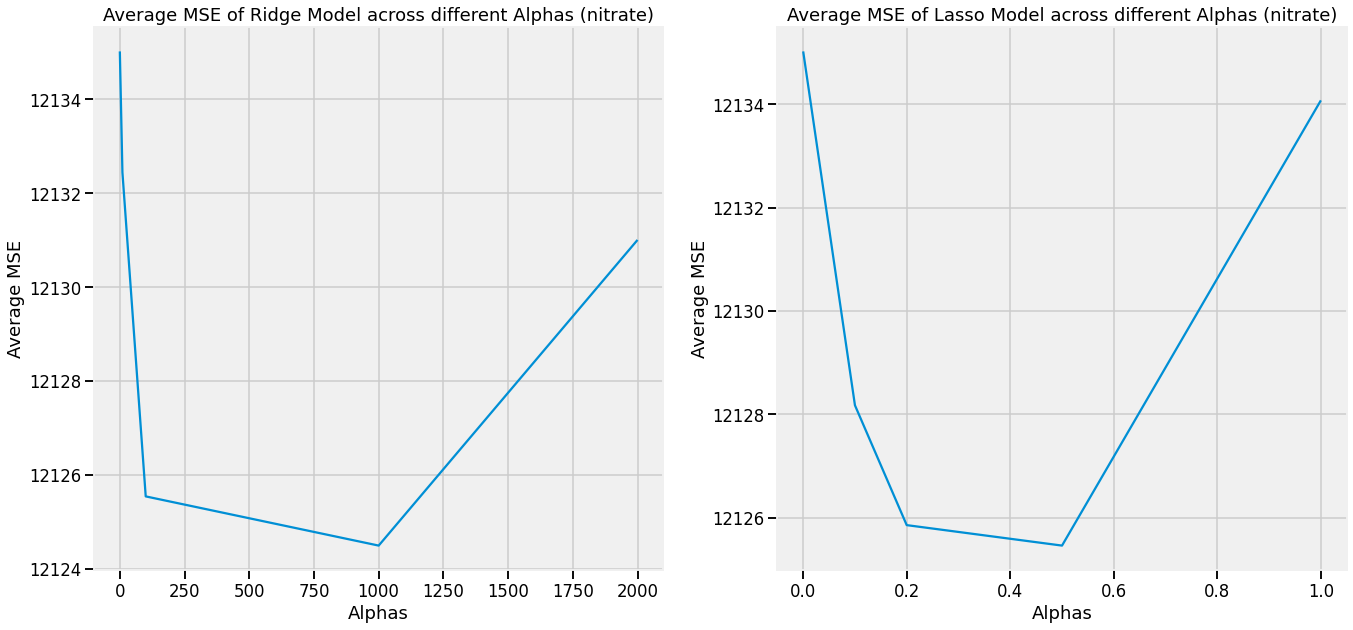

In [ ]:
alphas_ridge = [0, 10,100,1000,2000] # create an array or list of alpha values to test in Ridge regression
alphas_lasso = [0,0.1,0.2,0.5,1] # create an array or list of alpha values to test in Lasso regression

plt.figure(figsize = (20,10))

# Plot the cross-validated MSE versus alpha for ridge
plt.subplot(121)
plt.plot(alphas_ridge,model_cv_mse(Ridge, X_nitrate_train, y_nitrate_train,alphas_ridge, k = 10))
plt.title("Average MSE of Ridge Model across different Alphas (nitrate)")
plt.ylabel("Average MSE")
plt.xlabel("Alphas")

# Plot the cross-validated MSE versus alpha for Lasso
plt.subplot(122)
plt.plot(alphas_lasso,model_cv_mse(Lasso, X_nitrate_train, y_nitrate_train,alphas_lasso, k = 10))
plt.title("Average MSE of Lasso Model across different Alphas (nitrate)")
plt.ylabel("Average MSE")
plt.xlabel("Alphas")

plt.show()

##### 7.2.2 Parameter choice for arsenic

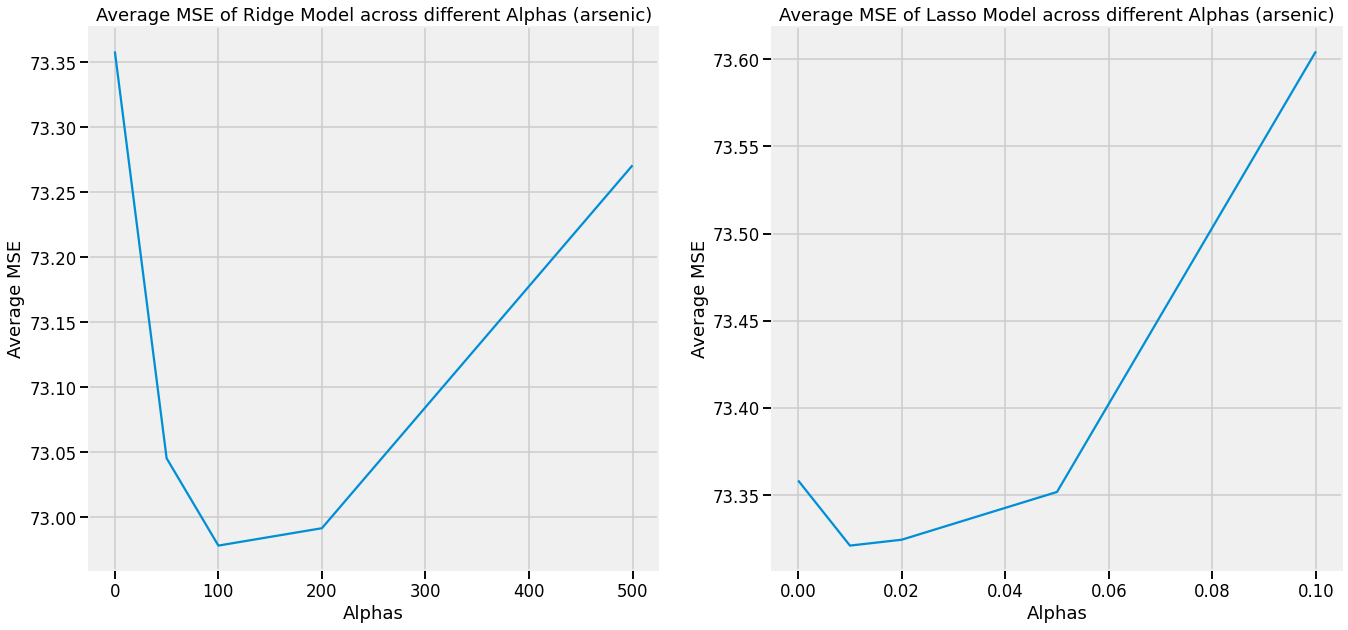

In [ ]:
alphas_ridge = [0,50,100,200,500] # create an array or list of alpha values to test in Ridge regression
alphas_lasso = [0,0.01,0.02,0.05,0.1] # create an array or list of alpha values to test in Lasso regression

plt.figure(figsize = (20,10))

# Plot the cross-validated MSE versus alpha for ridge
plt.subplot(121)
plt.plot(alphas_ridge,model_cv_mse(Ridge, X_arsenic_train, y_arsenic_train,alphas_ridge, k = 10))
plt.title("Average MSE of Ridge Model across different Alphas (arsenic)")
plt.ylabel("Average MSE")
plt.xlabel("Alphas")

# Plot the cross-validated MSE versus alpha for Lasso
plt.subplot(122)
plt.plot(alphas_lasso,model_cv_mse(Lasso, X_arsenic_train, y_arsenic_train,alphas_lasso, k = 10))
plt.title("Average MSE of Lasso Model across different Alphas (arsenic)")
plt.ylabel("Average MSE")
plt.xlabel("Alphas")

plt.show()

##### 7.2.3 Parameter choice for uranium

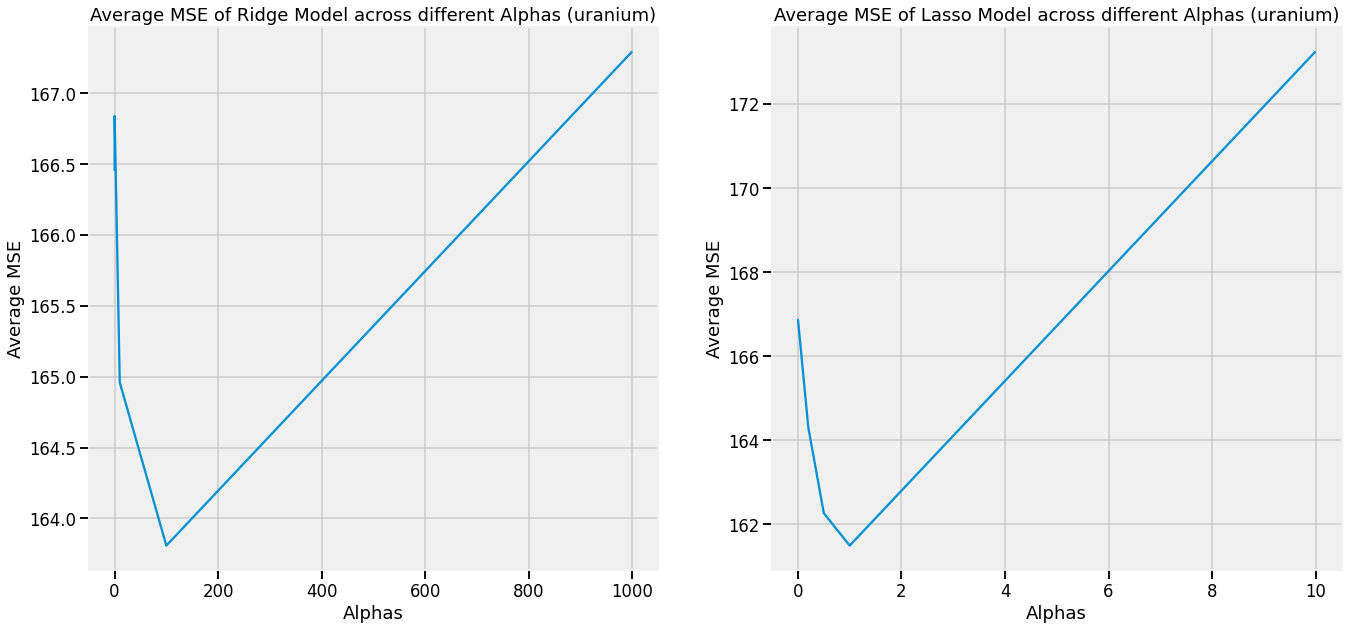

In [ ]:
alphas_ridge = [0, 0.1, 10,100,1000] # create an array or list of alpha values to test in Ridge regression
alphas_lasso = [0,0.2,0.5,1,10] # create an array or list of alpha values to test in Lasso regression

plt.figure(figsize = (20,10))

# Plot the cross-validated MSE versus alpha for ridge
plt.subplot(121)
plt.plot(alphas_ridge,model_cv_mse(Ridge, X_uranium_train, y_uranium_train,alphas_ridge, k = 10))
plt.title("Average MSE of Ridge Model across different Alphas (uranium)")
plt.ylabel("Average MSE")
plt.xlabel("Alphas")

# Plot the cross-validated MSE versus alpha for Lasso
plt.subplot(122)
plt.plot(alphas_lasso,model_cv_mse(Lasso, X_uranium_train, y_uranium_train,alphas_lasso, k = 10))
plt.title("Average MSE of Lasso Model across different Alphas (uranium)")
plt.ylabel("Average MSE")
plt.xlabel("Alphas")

plt.show()

##### 7.2.4 Parameter choice for TCPR

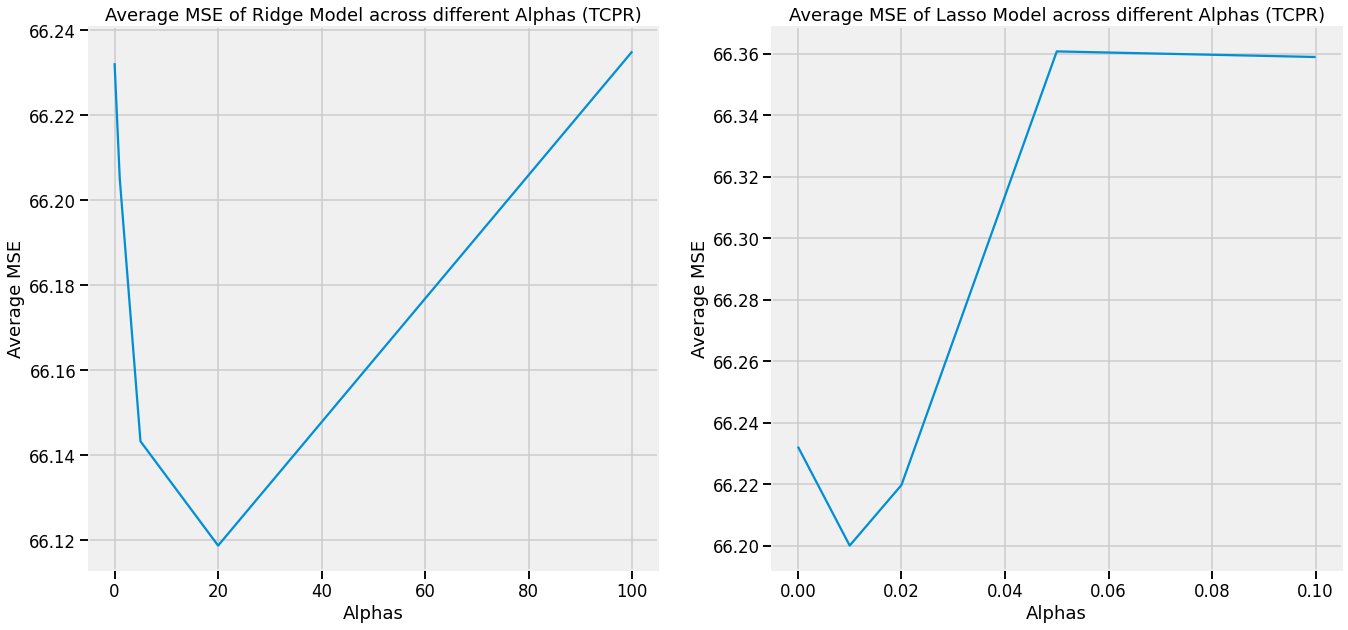

In [ ]:
alphas_ridge = [0,1,5,20,100] # create an array or list of alpha values to test in Ridge regression
alphas_lasso = [0,0.01,0.02,0.05,0.1] # create an array or list of alpha values to test in Lasso regression

plt.figure(figsize = (20,10))

# Plot the cross-validated MSE versus alpha for ridge
plt.subplot(121)
plt.plot(alphas_ridge,model_cv_mse(Ridge, X_TCPR_train, y_TCPR_train,alphas_ridge, k = 10))
plt.title("Average MSE of Ridge Model across different Alphas (TCPR)")
plt.ylabel("Average MSE")
plt.xlabel("Alphas")

# Plot the cross-validated MSE versus alpha for Lasso
plt.subplot(122)
plt.plot(alphas_lasso,model_cv_mse(Lasso, X_TCPR_train, y_TCPR_train,alphas_lasso, k = 10))
plt.title("Average MSE of Lasso Model across different Alphas (TCPR)")
plt.ylabel("Average MSE")
plt.xlabel("Alphas")

plt.show()


#### 7.3 Compare optimal model

In this section, we'll compare the performance of three models: Linear Regression, Lasso model with optimal alpha, Ridge model with optimal alpha.


##### 7.3.1 Compare optimal model for nitrate

In [ ]:
from sklearn.linear_model import RidgeCV

kf = KFold(n_splits = 10, shuffle = True, random_state = 8) # get KFold cross-validation selector object
ridgecv = RidgeCV(cv = kf, alphas=np.arange(35000,37000,10)) # pass CV object and list of alphas to RidgeCV()
ridgecv.fit(X_nitrate_train, y_nitrate_train) # fit RidgeCV model on training data

ridge_alpha_opt = ridgecv.alpha_ # get optimal alpha value
print("optimal alpha (nitrate):", ridge_alpha_opt)

y_pred_ridgecv = ridgecv.predict(X_nitrate_test)  # get test predictions using RidgeCV model

ridge_cv_mse = mean_squared_error(y_pred_ridgecv,y_nitrate_test) # get MSE of RidgeCV model
print("Test MSE with cross-validated Ridge (nitrate):", ridge_cv_mse)

optimal alpha (nitrate): 36210
Test MSE with cross-validated Ridge (nitrate): 9433.745430994164


In [ ]:
from sklearn.linear_model import LassoCV

kf = KFold(n_splits = 10, shuffle = True, random_state = 8) # get KFold cross-validation selector object
lassocv = LassoCV(cv = kf, alphas=np.arange(0.25,0.5,0.01)) # pass CV object and list of alphas to LassoCV()
lassocv.fit(X_nitrate_train, y_nitrate_train) # fit LassoCV model on training data

lasso_alpha_opt = lassocv.alpha_ # get optimal alpha value
print("optimal alpha (nitrate):", lasso_alpha_opt)

y_pred_lassocv = lassocv.predict(X_nitrate_test)  # get test predictions using LassoCV model

lasso_cv_mse = mean_squared_error(y_pred_lassocv,y_nitrate_test) # get MSE of LassoCV model
print("Test MSE with cross-validated Lasso (nitrate):", lasso_cv_mse)

optimal alpha (nitrate): 0.3900000000000001
Test MSE with cross-validated Lasso (nitrate): 9363.586936565298


In [ ]:
print("Linear Regression MSE for nitrate:",mse_nitrate[0])

Linear Regression MSE for nitrate: 9367.641428765524


Comparing with the three models, all of the MSE all quite high that might become a problem on predicting the NA value wells.

##### 7.3.2 Compare optimal model for arsenic

In [ ]:
from sklearn.linear_model import RidgeCV

kf = KFold(n_splits = 10, shuffle = True, random_state = 8) # get KFold cross-validation selector object
ridgecv = RidgeCV(cv = kf, alphas=np.arange(800,900,1)) # pass CV object and list of alphas to RidgeCV()
ridgecv.fit(X_arsenic_train, y_arsenic_train) # fit RidgeCV model on training data

ridge_alpha_opt = ridgecv.alpha_ # get optimal alpha value
print("optimal alpha (arsenic):", ridge_alpha_opt)

y_pred_ridgecv = ridgecv.predict(X_arsenic_test)  # get test predictions using RidgeCV model

ridge_cv_mse = mean_squared_error(y_pred_ridgecv,y_arsenic_test) # get MSE of RidgeCV model
print("Test MSE with cross-validated Ridge (arsenic):", ridge_cv_mse)

optimal alpha (arsenic): 859
Test MSE with cross-validated Ridge (arsenic): 72.77537577636956


In [ ]:
from sklearn.linear_model import LassoCV

kf = KFold(n_splits = 10, shuffle = True, random_state = 8) # get KFold cross-validation selector object
lassocv = LassoCV(cv = kf, alphas=np.arange(0,0.02,0.001)) # pass CV object and list of alphas to LassoCV()
lassocv.fit(X_arsenic_train, y_arsenic_train) # fit LassoCV model on training data

lasso_alpha_opt = lassocv.alpha_ # get optimal alpha value
print("optimal alpha (arsenic):", lasso_alpha_opt)

y_pred_lassocv = lassocv.predict(X_arsenic_test)  # get test predictions using LassoCV model

lasso_cv_mse = mean_squared_error(y_pred_lassocv,y_arsenic_test) # get MSE of LassoCV model
print("Test MSE with cross-validated Lasso (arsenic):", lasso_cv_mse)

optimal alpha (arsenic): 0.012
Test MSE with cross-validated Lasso (arsenic): 71.12172210323405


In [ ]:
print("Linear Regression MSE for arsenic:",mse_arsenic[0])

Linear Regression MSE for arsenic: 70.91206395036889


Comparing with the three models, Linear Regression MSE for arsenic: 70.91206395036889 is the lowest and should be considered as the most optimal one.

##### 7.3.3 Compare optimal model for uranium

In [ ]:
from sklearn.linear_model import RidgeCV

kf = KFold(n_splits = 10, shuffle = True, random_state = 8) # get KFold cross-validation selector object
ridgecv = RidgeCV(cv = kf, alphas=np.arange(10,100,1)) # pass CV object and list of alphas to RidgeCV()
ridgecv.fit(X_uranium_train, y_uranium_train) # fit RidgeCV model on training data

ridge_alpha_opt = ridgecv.alpha_ # get optimal alpha value
print("optimal alpha (uranium):", ridge_alpha_opt)

y_pred_ridgecv = ridgecv.predict(X_uranium_test)  # get test predictions using RidgeCV model

ridge_cv_mse = mean_squared_error(y_pred_ridgecv,y_uranium_test) # get MSE of RidgeCV model
print("Test MSE with cross-validated Ridge (uranium):", ridge_cv_mse)

optimal alpha (uranium): 63
Test MSE with cross-validated Ridge (uranium): 231.240507849726


In [ ]:
from sklearn.linear_model import LassoCV

kf = KFold(n_splits = 10, shuffle = True, random_state = 8) # get KFold cross-validation selector object
lassocv = LassoCV(cv = kf, alphas=np.arange(0,0.2,0.01)) # pass CV object and list of alphas to LassoCV()
lassocv.fit(X_uranium_train, y_uranium_train) # fit LassoCV model on training data

lasso_alpha_opt = lassocv.alpha_ # get optimal alpha value
print("optimal alpha (uranium):", lasso_alpha_opt)

y_pred_lassocv = lassocv.predict(X_uranium_test)  # get test predictions using LassoCV model

lasso_cv_mse = mean_squared_error(y_pred_lassocv,y_uranium_test) # get MSE of LassoCV model
print("Test MSE with cross-validated Lasso (uranium):", lasso_cv_mse)

optimal alpha (uranium): 0.19
Test MSE with cross-validated Lasso (uranium): 227.67379760765775


In [ ]:
print("Linear Regression MSE for uranium:",mse_uranium[0])

Linear Regression MSE for uranium: 228.82849861736716


Comparing with the three models, Test MSE with cross-validated Lasso (uranium): 227.67379760765775 is the lowest and should be considered as the most optimal one.

##### 7.3.4 Compare optimal model for TCPR

In [ ]:
from sklearn.linear_model import RidgeCV

kf = KFold(n_splits = 10, shuffle = True, random_state = 8) # get KFold cross-validation selector object
ridgecv = RidgeCV(cv = kf, alphas=np.arange(5,15,0.25)) # pass CV object and list of alphas to RidgeCV()
ridgecv.fit(X_TCPR_train, y_TCPR_train) # fit RidgeCV model on training data

ridge_alpha_opt = ridgecv.alpha_ # get optimal alpha value
print("optimal alpha (TCPR):", ridge_alpha_opt)

y_pred_ridgecv = ridgecv.predict(X_TCPR_test)  # get test predictions using RidgeCV model

ridge_cv_mse = mean_squared_error(y_pred_ridgecv,y_TCPR_test) # get MSE of RidgeCV model
print("Test MSE with cross-validated Ridge (TCPR):", ridge_cv_mse)

optimal alpha (TCPR): 14.75
Test MSE with cross-validated Ridge (TCPR): 74.35506842308237


In [ ]:
from sklearn.linear_model import LassoCV

kf = KFold(n_splits = 10, shuffle = True, random_state = 8) # get KFold cross-validation selector object
lassocv = LassoCV(cv = kf, alphas=np.arange(0,0.2,0.01)) # pass CV object and list of alphas to LassoCV()
lassocv.fit(X_TCPR_train, y_TCPR_train) # fit LassoCV model on training data

lasso_alpha_opt = lassocv.alpha_ # get optimal alpha value
print("optimal alpha (TCPR):", lasso_alpha_opt)

y_pred_lassocv = lassocv.predict(X_TCPR_test)  # get test predictions using LassoCV model

lasso_cv_mse = mean_squared_error(y_pred_lassocv,y_TCPR_test) # get MSE of LassoCV model
print("Test MSE with cross-validated Lasso (TCPR):", lasso_cv_mse)

optimal alpha (TCPR): 0.01
Test MSE with cross-validated Lasso (TCPR): 74.30173750249487


Comparing with the three models, Test MSE with cross-validated Lasso (TCPR): 74.30173750249487 is the lowest and should be considered as the most optimal one.

## Interpretation and Conclusions

#### 8.1 Address resource allocation question

In [ ]:
def get_X(df, cols_to_drop, strategy):
    """
    This function returns four dataframes containing the testing and training X and y values used in land-use regression.
    Input: df, a Pandas dataframe with all of the fields in the land-use regression dataset; 
        cols_to_drop, a list of the names (strings) of the columns to drop from df in order to obtain the feature variables.
        y_col, a column name (as a string) of df that represents the response variable
        test_size, a float between 0 and 1 indicating the fraction of the data to include in the test split
        random_state, an integer, used to define the random state
    Returns: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the 
    feature matrix X and response matrix y
    """
    
    # Replace the ellipses with your code
    X = df.drop(columns = cols_to_drop) # The X dataframe should be a subset of df; make sure to drop the columns in the cols_to_drop list
   
    # Standardize the data
    scaler = StandardScaler()
    scaler.fit(X) 
    X_stnd = scaler.transform(X)

    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imp.fit(X_stnd)
    SimpleImputer()
    X_stnd = imp.transform(X_stnd)

    return X_stnd

In [ ]:
df_nitrate_na = df[df['2019 Avg NO3 Cnc (mg/L)'].isna()]
df_nitrate_na.shape[0]
# There is no null value of nitrate. 

0

In [ ]:
df_arsenic_na = df[df['2019 Avg AS Cnc (mg/L)'].isna()]
X_arsenic_na = get_X(df_arsenic_na, total, "most_frequent")

model = LinearRegression()
model.fit(X_arsenic_train, y_arsenic_train)
y_arsenic_pred = model.predict(X_arsenic_na)
df_arsenic_na['2019 Avg AS Cnc (mg/L)'] = y_arsenic_pred

In [ ]:
df_uranium_na = df[df['2019 Avg UR Cnc (mg/L)'].isna()]
X_uranium_na = get_X(df_uranium_na, total, "most_frequent")

lassocv.fit(X_uranium_train, y_uranium_train) # fit LassoCV model on training data
lasso_alpha_opt = lassocv.alpha_ # get optimal alpha value
y_pred_uranium_lassocv = lassocv.predict(X_uranium_na)  # get test predictions using LassoCV model
df_uranium_na['2019 Avg UR Cnc (mg/L)'] = y_pred_uranium_lassocv

In [ ]:
df_TCPR_na = df[df['2019 Avg TCPR Cnc (mg/L)'].isna()]
X_TCPR_na = get_X(df_TCPR_na, total, "most_frequent")

lassocv.fit(X_TCPR_train, y_TCPR_train) # fit LassoCV model on training data
lasso_alpha_opt = lassocv.alpha_ # get optimal alpha value
y_pred_TCPR_lassocv = lassocv.predict(X_TCPR_na)  # get test predictions using LassoCV model
df_TCPR_na['2019 Avg TCPR Cnc (mg/L)'] = y_pred_TCPR_lassocv

In [ ]:
#convert to geodataframes
from shapely import wkt
df_arsenic_na['geometry'] = gpd.GeoSeries.from_wkt(df_arsenic_na['geometry'])
df_uranium_na['geometry'] = gpd.GeoSeries.from_wkt(df_uranium_na['geometry'])
df_TCPR_na['geometry'] = gpd.GeoSeries.from_wkt(df_TCPR_na['geometry'])

AS = gpd.GeoDataFrame(df_arsenic_na, geometry='geometry')
TCPR = gpd.GeoDataFrame(df_TCPR_na, geometry='geometry')
UR = gpd.GeoDataFrame(df_uranium_na, geometry='geometry')


#import county boundaries
counties = gpd.read_file('/content/drive/MyDrive/ER131_Final_Project/County_boundaries/CA_Counties_TIGER2016.shp')
counties = counties.to_crs(epsg=4326)

(34.0, 39.0)

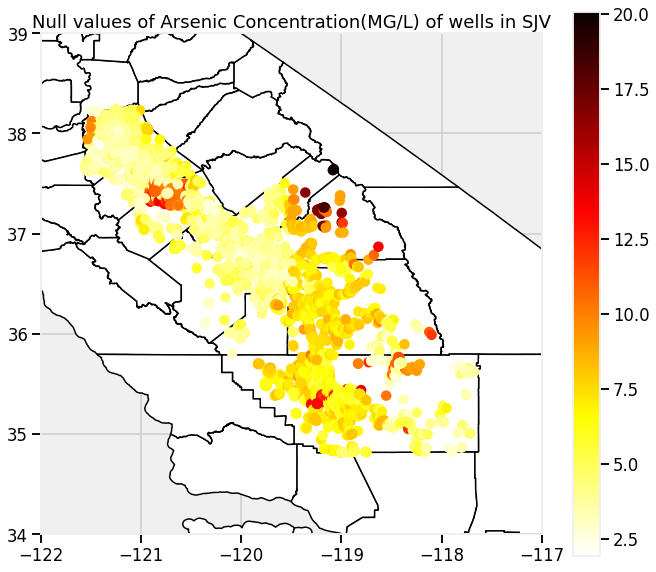

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_title("Null values of Arsenic Concentration(MG/L) of wells in SJV")
counties.plot(ax=ax, color='white', edgecolor='black',zorder = 1)
AS.plot(ax = ax, column = '2019 Avg AS Cnc (mg/L)',cmap='hot_r',legend=True)
plt.xlim([-122,-117])
plt.ylim([34,39])

(34.0, 39.0)

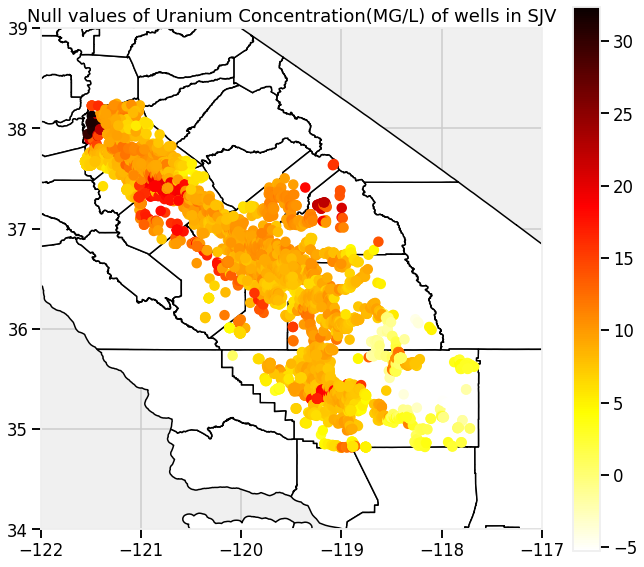

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_title("Null values of Uranium Concentration(MG/L) of wells in SJV")
counties.plot(ax=ax, color='white', edgecolor='black',zorder = 1)
UR.plot(ax = ax, column = '2019 Avg UR Cnc (mg/L)',cmap='hot_r',legend=True)
plt.xlim([-122,-117])
plt.ylim([34,39])

(34.0, 39.0)

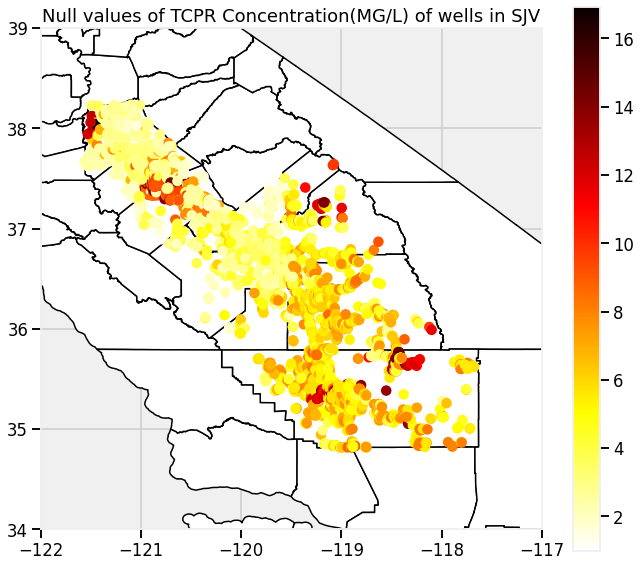

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_title("Null values of TCPR Concentration(MG/L) of wells in SJV")
counties.plot(ax=ax, color='white', edgecolor='black',zorder = 1)
TCPR.plot(ax = ax, column = '2019 Avg TCPR Cnc (mg/L)',cmap='hot_r',legend=True)
plt.xlim([-122,-117])
plt.ylim([34,39])

Rural and unincorporated communities are most at risk for negative health effects associated with consuming water contaminated with nitrates, arsenic, 1,2,3-trichloropropane (1,2,3-TCP), and uranium
. The pollutant concentrations tend to be higher in certain census tracts with high population density. However, many rural areas lack groundwater monitoring data, limiting the accuracy of CalEnviroScreen’s water quality predictions. Therefore, we come up with a resource allocation question to predict the wells that lack pollution monitoring data specifically in terms of four contaminants by using available features including land use, soil classification, distance to coal mines, and distance to coal power plants. 

To help the policymaker better improve their resource allocation in addressing water quality, we believe that CalEnviroScreen should include our predicted concentration of water contaminants instead of averaging concentrations from 2011-2019 of each contaminant based on the census tract. Second, we also generate a map that expresses the geographic distribution of chemical pollution in San Joaquin Valley. As shown in the figures of this section, several major cities, including Stockton and Turlock, have reported relatively high values in all four types of contaminants. Also, several rural places especially the foothills of the Sierra Nevada’s have shown an extremely high concentration of a chemical contaminant that requires the local policymaker to urgently deal with.

Moreover, nitrates have been found to become a serious question in the San Joaquin Valley, affecting over 250,000 people in communities that are poor and rural. Our experimental data analysis also shows that more the 29.8% of water supply that had nitrate levels above the 10 mg/L MCL the drinking water legal limit. More importantly, nitrate pollution does not come from a few specific pollution sources. Due to its widespread agriculture production, nitrate pollution spreads all over the valley. Thus, the readers would be careful about our prediction model, because it includes a couple of indicators that could be potentially positively related to the degree of contamination.  


##### 8.2 Reflection on modeling

Our results could have been potentially flawed as shown below. First, our four models mainly align with the regularization method (Ridge and Lasso) to overcome the problem of potential overfitting. However, when we run through the code and find out that the R-squared value is pretty low for all of the training models. This could suggest that our model might have a high bias with the underfitting issue. Because overfitting is usually occurring when the model is too complex and thus leads to a high value of R-squared value. Second, we have a relatively high value of MSE in all four models, especially with the nitrate concentration. This result suggests that our model might not perform well in predicting nitrate concentration. The reason for such flaw could be explained by the weak correlation between our selected features (distance to power plants, Hazardous Waste, soil type, annual precipitation) and response variables. Nitrate is closely connected to agriculture production across the San Joaquin valley. However, we fail to find appropriate features to represent the agricultural feralization usage due to a lack of data availability and credibility. Finally, some of our data is out of date and challenges the internal validity of the model. For instance, we fail to find any newest update of soil type and texture data since 2011. To improve our result, we believe that domain knowledge is necessary and important for us to decide which features should be included in our model to enhance the performance. 

**Citations:**

Ayres, A., Hanak, E., McCann, H., Mitchell, D., Sugg, Z., &amp; Rugland, E. (2021, September 20). Groundwater and urban growth in the San Joaquin Valley. Public Policy Institute of California. Retrieved December 2, 2021, from https://www.ppic.org/publication/groundwater-and-urban-growth-in-the-san-joaquin-valley/

Balazs, C., &amp; Morello-Frosch, R. (2011, September). Social disparities in nitrate-contaminated drinking water in California's San Joaquin Valley. Environmental health perspectives. Retrieved December 13, 2021, from https://pubmed.ncbi.nlm.nih.gov/21642046/. 

Del Real, J. (2019, May 21). They grow the nation’s food, but they can’t drink the water. The New York Times. Retrieved December 1, 2021, from https://www.nytimes.com/2019/05/21/us/california-central-valley-tainted-water.html. 

Hubler, S. (2021, November 6). This Is Where the States Want Billions in Infrastructure Funding Spent. The New York Times. 

MacLeod, C., &amp; Estelí Méndez-Barrientos, L. (2019). Groundwater Management in California’s Central Valley: A Focus on Disadvantaged Communities . Case Studies in the Environment. https://doi.org/https://doi.org/10.1525/cse.2018.001883 

Ziese, L., &amp; Blumenfeld, J. (2021, October). CalEnviroScreen 4.0 Report. Retrieved from https://oehha.ca.gov/media/downloads/calenviroscreen/report/calenviroscreen40reportf2021.pdf. 